# **BİL 443 - PATTERN RECOGNITION**

MARKET CRASH DETECTION
-----------------------------
ELIF RANA TEKIN
201401006

VIDEO LINK

https://drive.google.com/file/d/1yWHAimq5a1XmZnO6_-92wGXI9rCowgJ6/view?usp=sharing

## **EDA**

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def download_market_data(ticker, start_date, end_date):
    """Download market data from Yahoo Finance."""
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def calculate_returns(data):
    """Calculate daily and rolling returns."""
    # Daily returns
    data['Return'] = data['Close'].pct_change() * 100
    
    # Log returns (more suitable for statistical analysis)
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1)) * 100
    
    # Different period returns
    data['Weekly_Return'] = data['Close'].pct_change(5) * 100
    data['Monthly_Return'] = data['Close'].pct_change(21) * 100
    data['Quarterly_Return'] = data['Close'].pct_change(63) * 100
    
    # Volatility measures
    data['Rolling_Vol_10d'] = data['Return'].rolling(10).std()
    data['Rolling_Vol_30d'] = data['Return'].rolling(30).std()
    
    return data.dropna()

def detect_crashes(data, lookback_period_years=7, method='std_dev', std_dev_threshold=-2.5):
    """
    Detect market crashes using either:
    1. Le Bris' rolling standard deviation methodology
    2. Boxplot outlier detection (Tukey's method)
    
    Parameters:
    -----------
    data : DataFrame
        DataFrame containing market data with 'Return' column
    lookback_period_years : int
        Number of years to look back for establishing the market context
    method : str
        'std_dev' for Le Bris' method or 'boxplot' for Tukey's boxplot method
    std_dev_threshold : float
        Threshold for standard deviation method (only used if method='std_dev')
        
    Returns:
    --------
    DataFrame with crash detection columns added
    """
    # Convert lookback period from years to trading days (approx 252 trading days per year)
    lookback_days = int(lookback_period_years * 252)
    
    if method == 'std_dev':
        # Le Bris' method: Calculate rolling mean and standard deviation
        data['Rolling_Mean'] = data['Return'].rolling(window=lookback_days).mean()
        data['Rolling_Std'] = data['Return'].rolling(window=lookback_days).std()
        
        # Calculate adjusted returns (in terms of standard deviations)
        data['Adjusted_Return'] = (data['Return'] - data['Rolling_Mean']) / data['Rolling_Std']
        
    elif method == 'boxplot':
        # Boxplot method using rolling windows
        def rolling_boxplot_stats(x):
            q1 = np.percentile(x, 25)
            q3 = np.percentile(x, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            return lower_bound
        
        # Calculate the lower bound of boxplot for each rolling window
        data['Boxplot_Lower_Bound'] = data['Return'].rolling(window=lookback_days).apply(
            rolling_boxplot_stats, raw=True
        )
        
        # Calculate how far each return is below the lower bound (positive = below bound)
        data['Boxplot_Outlier_Distance'] = data['Boxplot_Lower_Bound'] - data['Return']
        data.loc[data['Boxplot_Outlier_Distance'] <= 0, 'Boxplot_Outlier_Distance'] = 0
        
        # For compatibility, also calculate the adjusted return as in Le Bris method
        data['Rolling_Mean'] = data['Return'].rolling(window=lookback_days).mean()
        data['Rolling_Std'] = data['Return'].rolling(window=lookback_days).std()
        data['Adjusted_Return'] = (data['Return'] - data['Rolling_Mean']) / data['Rolling_Std']
    
    return data.dropna()

def label_crashes(data, method='std_dev', threshold=-2.5):
    """
    Label crashes based on the detection method chosen.
    
    Parameters:
    -----------
    data : DataFrame
        DataFrame with crash detection metrics
    method : str
        'std_dev' for standard deviation based or 'boxplot' for boxplot outlier based
    threshold : float
        For std_dev: threshold in standard deviations
        For boxplot: not used (outliers already defined by Tukey's method)
    """
    data['Crash'] = 0
    
    if method == 'std_dev':
        # Label crashes using standard deviation approach
        data.loc[data['Adjusted_Return'] < threshold, 'Crash'] = 1
    elif method == 'boxplot':
        # Label crashes using boxplot approach - any outlier below lower bound
        data.loc[data['Boxplot_Outlier_Distance'] > 0, 'Crash'] = 1
    
    # Also create a forward-looking crash indicator for prediction purposes
    data['Crash_Next_Month'] = data['Crash'].shift(-21)  # ~21 trading days in a month
    
    return data.dropna()

def exploratory_data_analysis(data):
    """
    Comprehensive exploratory data analysis for market crash detection
    """
    # Set up the overall figure style
    sns.set(style="whitegrid", font_scale=1.2)
    plt.rcParams['figure.figsize'] = [12, 8]
    
    # Create output directory for plots
    import os
    if not os.path.exists('eda_plots'):
        os.makedirs('eda_plots')
    
    print("Starting Exploratory Data Analysis...")
    print(f"Data ranges from {data.index.min().date()} to {data.index.max().date()}")
    print(f"Total days: {len(data)}")
    
    # 1. Basic Returns Distribution Analysis
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(data['Return'], kde=True, bins=100)
    plt.title('Distribution of Daily Returns')
    plt.axvline(0, color='r', linestyle='--')
    
    plt.subplot(2, 2, 2)
    stats.probplot(data['Return'], plot=plt)
    plt.title('QQ Plot of Daily Returns')
    
    plt.subplot(2, 2, 3)
    sns.histplot(data['Log_Return'], kde=True, bins=100, color='green')
    plt.title('Distribution of Log Returns')
    plt.axvline(0, color='r', linestyle='--')
    
    plt.subplot(2, 2, 4)
    stats.probplot(data['Log_Return'], plot=plt)
    plt.title('QQ Plot of Log Returns')
    
    plt.tight_layout()
    plt.savefig('eda_plots/returns_distribution.png')
    
    # 2. Time Series Analysis
    plt.figure(figsize=(14, 12))
    
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['Close'])
    plt.title('Market Price Over Time')
    plt.yscale('log')  # Log scale to handle exponential growth
    
    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['Return'])
    crash_dates = data[data['Crash'] == 1].index
    for date in crash_dates:
        plt.axvline(x=date, color='r', alpha=0.2)
    plt.title('Daily Returns with Crash Markers')
    
    plt.subplot(3, 1, 3)
    plt.plot(data.index, data['Rolling_Vol_30d'])
    for date in crash_dates:
        plt.axvline(x=date, color='r', alpha=0.2)
    plt.title('30-Day Rolling Volatility with Crash Markers')
    
    plt.tight_layout()
    plt.savefig('eda_plots/time_series_analysis.png')
    
    # 3. Crash Characteristics Analysis
    plt.figure(figsize=(14, 12))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(x='Crash', y='Return', data=data)
    plt.title('Return Distribution: Crash vs Non-Crash Days')
    
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Crash', y='Rolling_Vol_30d', data=data)
    plt.title('30-Day Volatility: Crash vs Non-Crash Days')
    
    # Distribution of return by day of the week
    plt.subplot(2, 2, 3)
    data['DayOfWeek'] = data.index.dayofweek
    crash_by_dow = data.groupby('DayOfWeek')['Crash'].mean() * 100
    crash_by_dow.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    crash_by_dow.plot(kind='bar')
    plt.title('Crash Frequency by Day of Week (%)')
    
    # Distribution of crash by month
    plt.subplot(2, 2, 4)
    data['Month'] = data.index.month
    crash_by_month = data.groupby('Month')['Crash'].mean() * 100
    crash_by_month.plot(kind='bar')
    plt.title('Crash Frequency by Month (%)')
    
    plt.tight_layout()
    plt.savefig('eda_plots/crash_characteristics.png')
    
    # 4. Autocorrelation analysis - are crashes clustered?
    plt.figure(figsize=(14, 6))
    
    try:
        # Use matplotlib directly instead of statsmodels for more control
        from matplotlib.pyplot import acorr, xcorr
        
        lags = 30
        plt.subplot(1, 2, 1)
        crash_series = data['Crash'].values
        autocorr_values = [1] + [np.corrcoef(crash_series[:-i], crash_series[i:])[0,1] for i in range(1, lags+1)]
        plt.stem(range(lags+1), autocorr_values, linefmt='b-', markerfmt='bo', basefmt='r-')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axhline(y=1.96/np.sqrt(len(data)), color='r', linestyle='--', alpha=0.7)
        plt.axhline(y=-1.96/np.sqrt(len(data)), color='r', linestyle='--', alpha=0.7)
        plt.title('Autocorrelation of Crash Events')
        plt.xlabel('Lag (Days)')
        plt.ylabel('Autocorrelation')
        plt.grid(True)
        
        # Partial autocorrelation - calculate manually
        plt.subplot(1, 2, 2)
        
        # Function to calculate PACF manually
        def pacf(x, nlags):
            pacf_values = [1]  # Lag 0 is always 1
            
            # For each lag, fit an AR model and get the last coefficient
            for lag in range(1, nlags + 1):
                # Create lagged variables for AR model
                X = np.zeros((len(x) - lag, lag))
                for i in range(lag):
                    X[:, i] = x[lag - i - 1:len(x) - i - 1]
                y = x[lag:]
                
                # Fit AR model using OLS
                try:
                    beta = np.linalg.inv(X.T @ X) @ X.T @ y
                    pacf_values.append(beta[-1])  # Last coefficient is the PACF
                except:
                    # If matrix is singular, use the autocorrelation instead
                    pacf_values.append(np.corrcoef(x[:-lag], x[lag:])[0,1])
            
            return pacf_values
        
        # Calculate PACF
        pacf_values = pacf(crash_series, lags)
        
        # Plot PACF
        plt.stem(range(lags+1), pacf_values, linefmt='b-', markerfmt='bo', basefmt='r-')
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axhline(y=1.96/np.sqrt(len(data)), color='r', linestyle='--', alpha=0.7)
        plt.axhline(y=-1.96/np.sqrt(len(data)), color='r', linestyle='--', alpha=0.7)
        plt.title('Partial Autocorrelation of Crash Events')
        plt.xlabel('Lag (Days)')
        plt.ylabel('Partial Autocorrelation')
        plt.grid(True)
    
    except Exception as e:
        print(f"Error generating autocorrelation plots: {e}")
        # Fallback to a simpler plot if the advanced method fails
        plt.subplot(1, 1, 1)
        pd.Series(data['Crash']).autocorr(lag=range(1,31)).plot(kind='bar')
        plt.title('Autocorrelation of Crash Events (Simple Method)')
        plt.xlabel('Lag (Days)')
        plt.ylabel('Autocorrelation')
    
    plt.tight_layout()
    plt.savefig('eda_plots/crash_autocorrelation.png')
    
    # 5. Volatility Regimes Analysis
    plt.figure(figsize=(14, 8))
    
    # Apply kernel density estimation to see clustering of volatility regimes
    plt.subplot(2, 1, 1)
    sns.kdeplot(data=data, x='Return', y='Rolling_Vol_30d', fill=True, cmap='viridis')
    plt.title('Volatility Regimes (Return vs 30-Day Volatility)')
    plt.scatter(data.loc[data['Crash'] == 1, 'Return'], 
               data.loc[data['Crash'] == 1, 'Rolling_Vol_30d'],
               color='red', alpha=0.5, s=20)
    
    # Rolling volatility over time with crash markers
    plt.subplot(2, 1, 2)
    plt.plot(data.index, data['Rolling_Vol_30d'], alpha=0.7)
    plt.plot(data.index, data['Rolling_Vol_10d'], alpha=0.5, color='green')
    for date in crash_dates:
        plt.axvline(x=date, color='r', alpha=0.2)
    plt.title('Volatility Regimes Over Time with Crash Markers')
    plt.legend(['30-Day Volatility', '10-Day Volatility', 'Crashes'])
    
    plt.tight_layout()
    plt.savefig('eda_plots/volatility_regimes.png')
    
    # 6. Correlation Analysis
    # Create additional features that might be correlated with crashes
    data['Return_Prev_1d'] = data['Return'].shift(1)
    data['Return_Prev_2d'] = data['Return'].shift(2)
    data['Return_Prev_3d'] = data['Return'].shift(3)
    data['Return_Prev_Week'] = data['Return'].rolling(5).sum().shift(1)
    data['Vol_Change'] = data['Rolling_Vol_30d'].pct_change(5)
    
    corr_features = ['Return', 'Return_Prev_1d', 'Return_Prev_2d', 'Return_Prev_3d',
                    'Return_Prev_Week', 'Rolling_Vol_10d', 'Rolling_Vol_30d', 
                    'Vol_Change', 'Crash']
    
    plt.figure(figsize=(12, 10))
    corr_matrix = data[corr_features].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Market Features')
    plt.tight_layout()
    plt.savefig('eda_plots/correlation_matrix.png')
    
    # 7. Crash Severity Analysis
    if 'Boxplot_Outlier_Distance' in data.columns:
        plt.figure(figsize=(12, 8))
        
        crash_data = data[data['Crash'] == 1].copy()
        crash_data['Year'] = crash_data.index.year
        
        # Severity by year
        plt.subplot(2, 1, 1)
        crash_severity_by_year = crash_data.groupby('Year')['Boxplot_Outlier_Distance'].mean()
        crash_severity_by_year.plot(kind='bar', color='darkred')
        plt.title('Average Crash Severity by Year')
        plt.ylabel('Average Outlier Distance')
        
        # Histogram of crash severity
        plt.subplot(2, 1, 2)
        sns.histplot(crash_data['Boxplot_Outlier_Distance'], bins=20, kde=True, color='darkred')
        plt.title('Distribution of Crash Severity')
        plt.xlabel('Outlier Distance (higher = more severe)')
        
        plt.tight_layout()
        plt.savefig('eda_plots/crash_severity.png')
    
    # 8. Market State Before Crashes
    plt.figure(figsize=(14, 10))
    
    # Get periods before crashes
    crash_dates = data[data['Crash'] == 1].index
    
    # Compute average returns before crashes (30 days)
    avg_returns_before_crash = []
    days_before = 30
    
    for i in range(1, days_before + 1):
        avg_return = np.mean([data.loc[date - pd.Timedelta(days=i), 'Return'] 
                            for date in crash_dates if date - pd.Timedelta(days=i) in data.index])
        avg_returns_before_crash.append(avg_return)
    
    plt.subplot(2, 1, 1)
    plt.plot(range(1, days_before + 1), avg_returns_before_crash[::-1])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Average Daily Returns in the 30 Days Leading to Crashes')
    plt.xlabel('Days Before Crash')
    plt.ylabel('Average Return (%)')
    
    # Volatility before crashes
    avg_vol_before_crash = []
    for i in range(1, days_before + 1):
        avg_vol = np.mean([data.loc[date - pd.Timedelta(days=i), 'Rolling_Vol_10d'] 
                           for date in crash_dates if date - pd.Timedelta(days=i) in data.index])
        avg_vol_before_crash.append(avg_vol)
    
    plt.subplot(2, 1, 2)
    plt.plot(range(1, days_before + 1), avg_vol_before_crash[::-1], color='green')
    plt.title('Average 10-Day Volatility in the 30 Days Leading to Crashes')
    plt.xlabel('Days Before Crash')
    plt.ylabel('Average Volatility')
    
    plt.tight_layout()
    plt.savefig('eda_plots/market_state_before_crashes.png')
    
    # 9. Recurrence and Persistence Analysis
    plt.figure(figsize=(12, 8))
    
    # Count number of crash days per year
    data['Year'] = data.index.year
    crash_days_per_year = data.groupby('Year')['Crash'].sum()
    
    plt.subplot(2, 1, 1)
    crash_days_per_year.plot(kind='bar')
    plt.title('Number of Crash Days per Year')
    plt.ylabel('Count')
    
    # Calculate duration of crash clusters
    # A cluster is defined as consecutive days with crashes
    data['Crash_Cluster'] = (data['Crash'].diff() == 1).cumsum()
    cluster_durations = data[data['Crash'] == 1].groupby('Crash_Cluster').size()
    
    plt.subplot(2, 1, 2)
    sns.histplot(cluster_durations, bins=range(1, max(cluster_durations) + 2), discrete=True)
    plt.title('Distribution of Crash Cluster Durations')
    plt.xlabel('Consecutive Crash Days')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('eda_plots/crash_recurrence.png')
    
    # 10. Summary statistics in text form
    print("\n--- SUMMARY STATISTICS ---")
    print("\nReturn Statistics:")
    print(data[['Return', 'Log_Return', 'Weekly_Return', 'Monthly_Return']].describe().round(2))
    
    print("\nCrash Statistics:")
    print(f"Total crash days: {data['Crash'].sum()}")
    print(f"Percentage of crash days: {data['Crash'].mean()*100:.2f}%")
    print(f"Average return on crash days: {data.loc[data['Crash'] == 1, 'Return'].mean():.2f}%")
    print(f"Average volatility on crash days: {data.loc[data['Crash'] == 1, 'Rolling_Vol_30d'].mean():.4f}")
    
    # Calculate periods between crashes
    crash_dates_list = data[data['Crash'] == 1].index.tolist()
    days_between_crashes = [(crash_dates_list[i] - crash_dates_list[i-1]).days 
                            for i in range(1, len(crash_dates_list))]
    
    if days_between_crashes:
        print(f"Average days between crashes: {np.mean(days_between_crashes):.1f}")
        print(f"Median days between crashes: {np.median(days_between_crashes):.1f}")
    
    print("\nEDA complete! All plots saved to 'eda_plots' directory.")
    
    return data

def eda(detection_method='boxplot', std_dev_threshold=-2.5, ticker = '^GSPC'):
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=30*12*20)).strftime('%Y-%m-%d')  # 20 years
    
    
    print(f"Analyzing {ticker} from {start_date} to {end_date}")
    print(f"Using {detection_method} method for crash detection")
    
    # Download and process data
    data = download_market_data(ticker, start_date, end_date)
    data = calculate_returns(data)
    data = detect_crashes(data, method=detection_method, std_dev_threshold=std_dev_threshold)
    data = label_crashes(data, method=detection_method, threshold=std_dev_threshold)
    
    # Run exploratory data analysis
    data = exploratory_data_analysis(data)
    
    # Save the processed data for later use
    data.to_csv('market_data_with_crashes.csv')
    print("Processed data saved to 'market_data_with_crashes.csv'")


[*********************100%***********************]  1 of 1 completed

Analyzing ^GSPC from 2005-07-22 to 2025-04-08
Using boxplot method for crash detection


Starting Exploratory Data Analysis...
Data ranges from 2012-10-19 to 2025-03-07
Total days: 3112

--- SUMMARY STATISTICS ---

Return Statistics:
Price    Return Log_Return Weekly_Return Monthly_Return
Ticker                                                 
count   3112.00    3112.00       3112.00        3112.00
mean       0.05       0.04          0.25           1.05
std        1.06       1.06          2.18           4.19
min      -11.98     -12.77        -17.97         -32.97
25%       -0.37      -0.37         -0.69          -0.86
50%        0.07       0.07          0.40           1.51
75%        0.56       0.56          1.41           3.46
max        9.38       8.97         17.40          25.11

Crash Statistics:
Total crash days: 130
Percentage of crash days: 4.18%
Average return on crash days: -2.71%
Average volatility on crash days: 1.5815
Average days between crashes: 34.3
Median days between crashes: 7.0

EDA complete! All plots saved to 'eda_plots' directory.
Processed data save

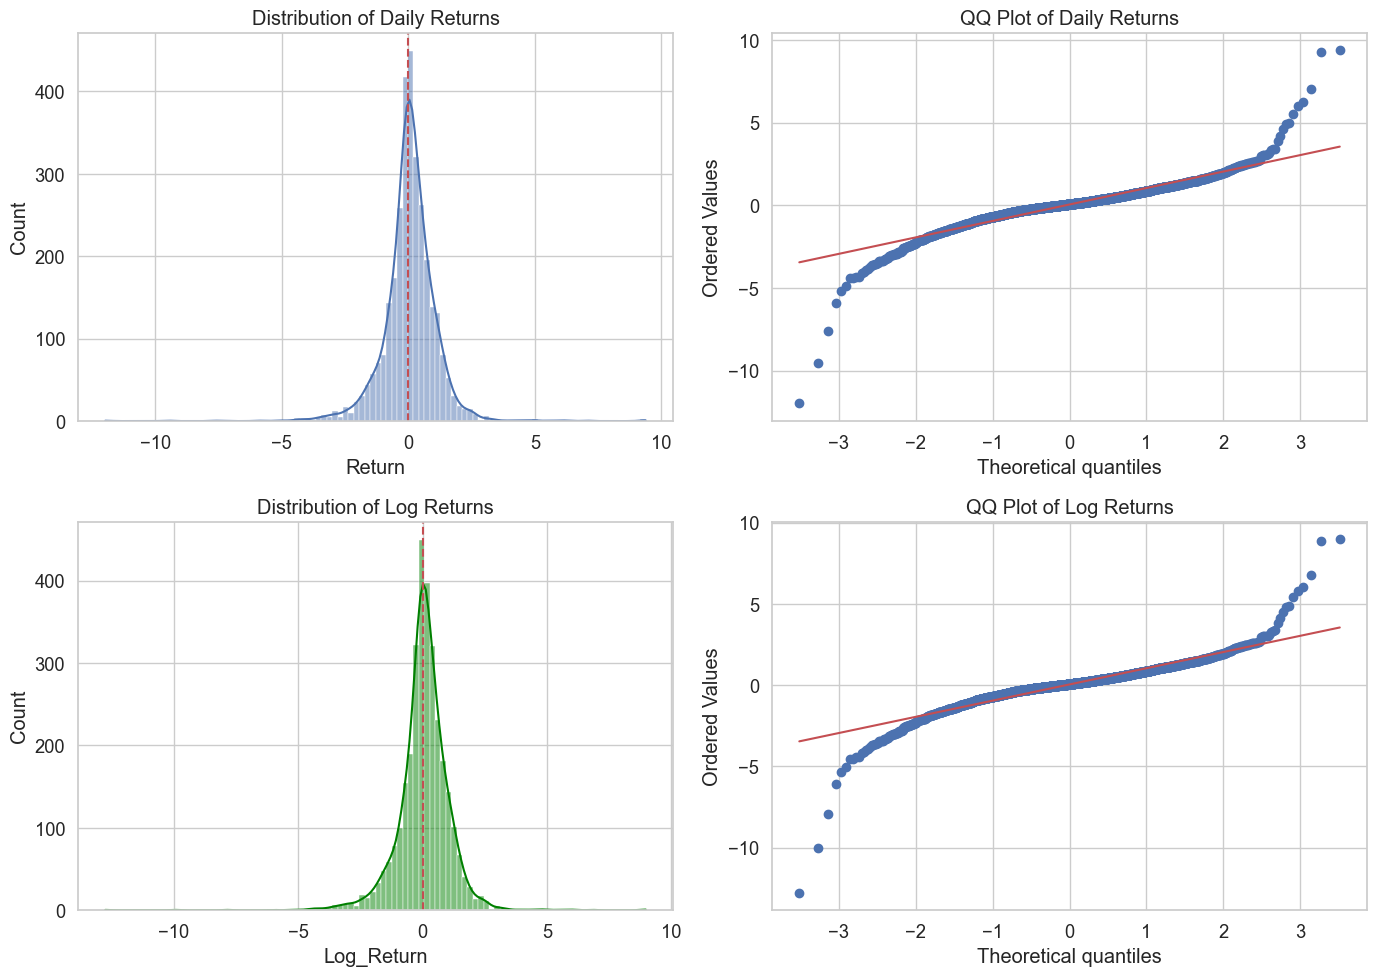

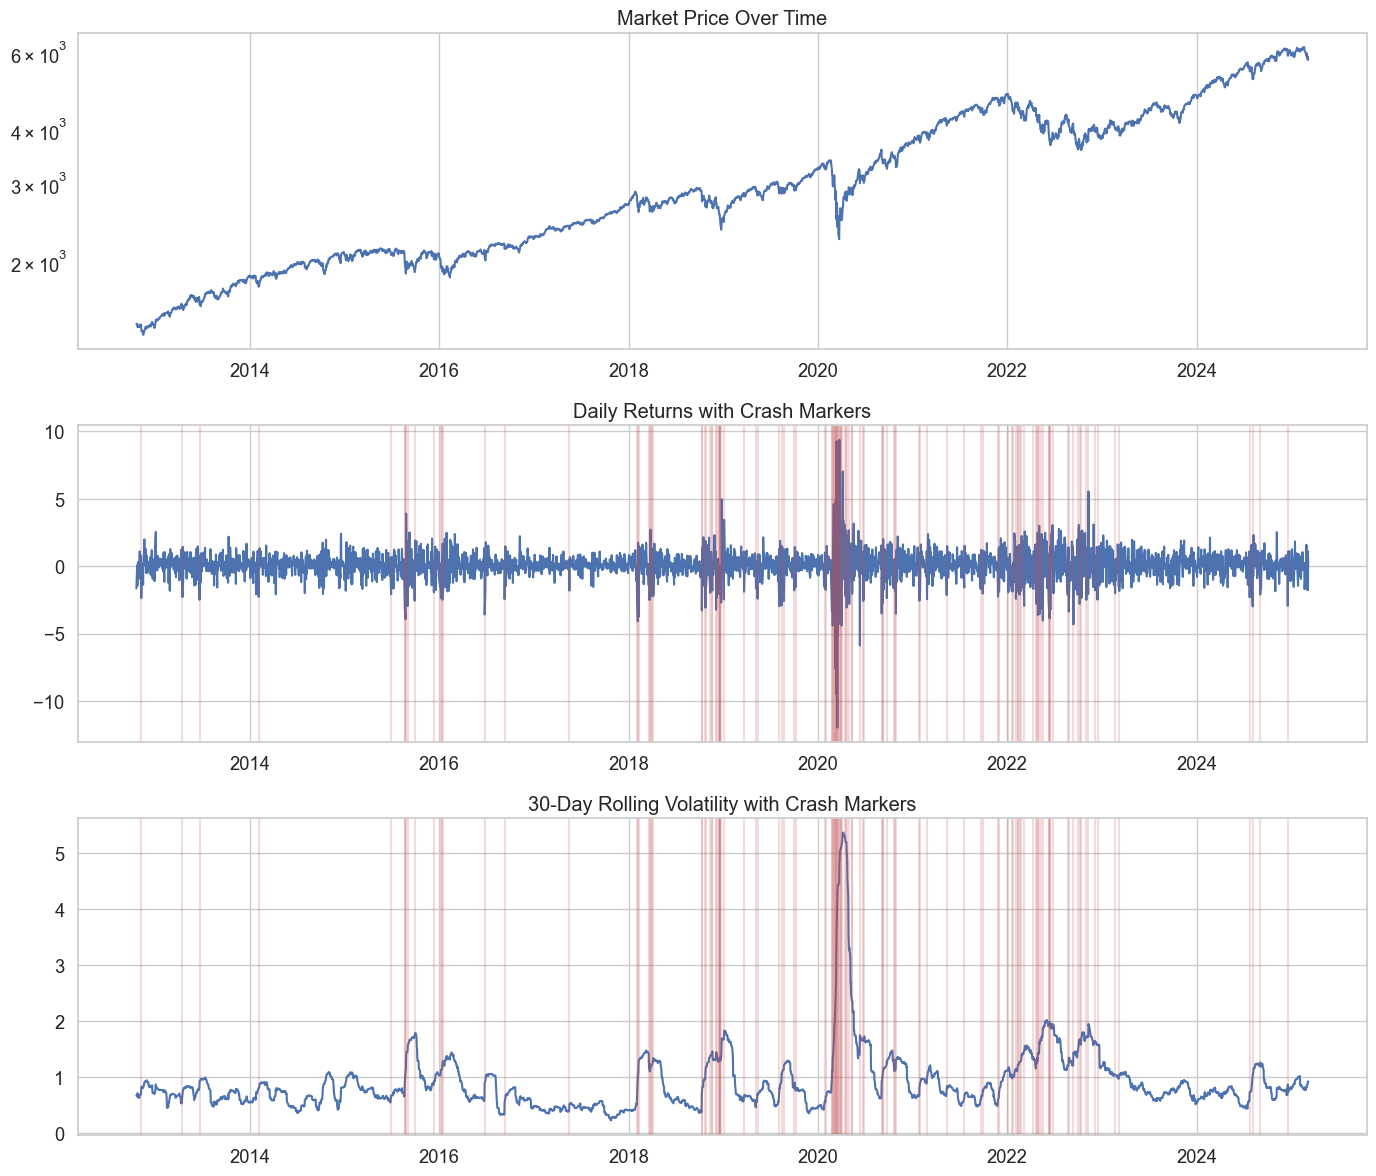

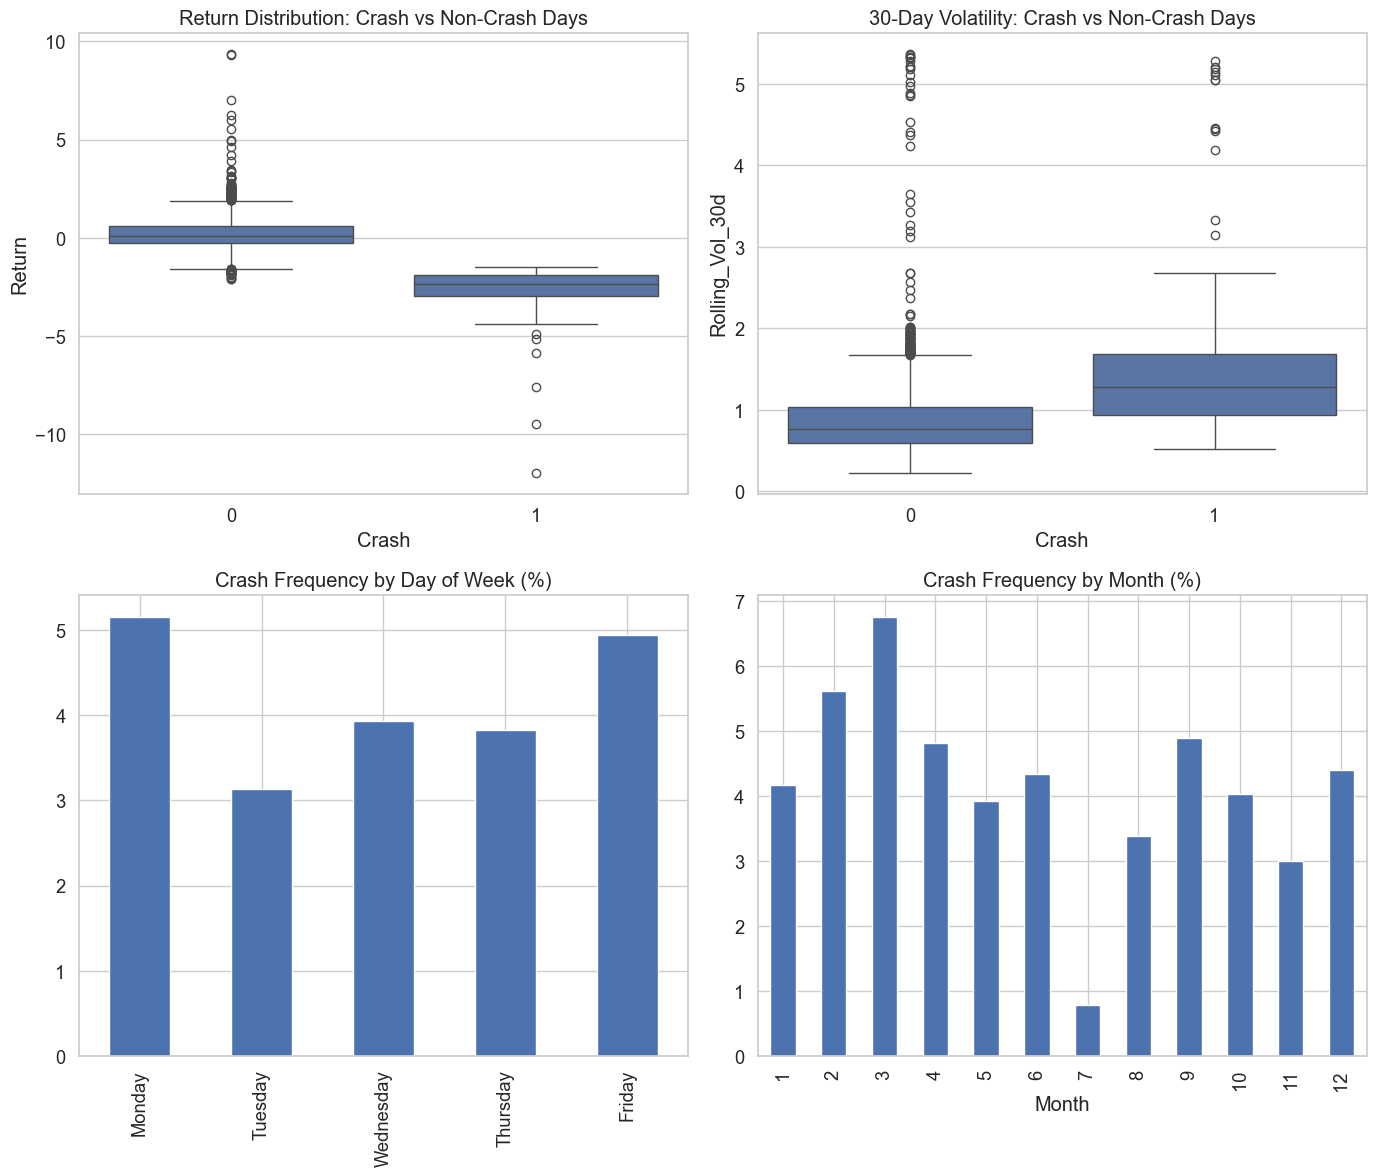

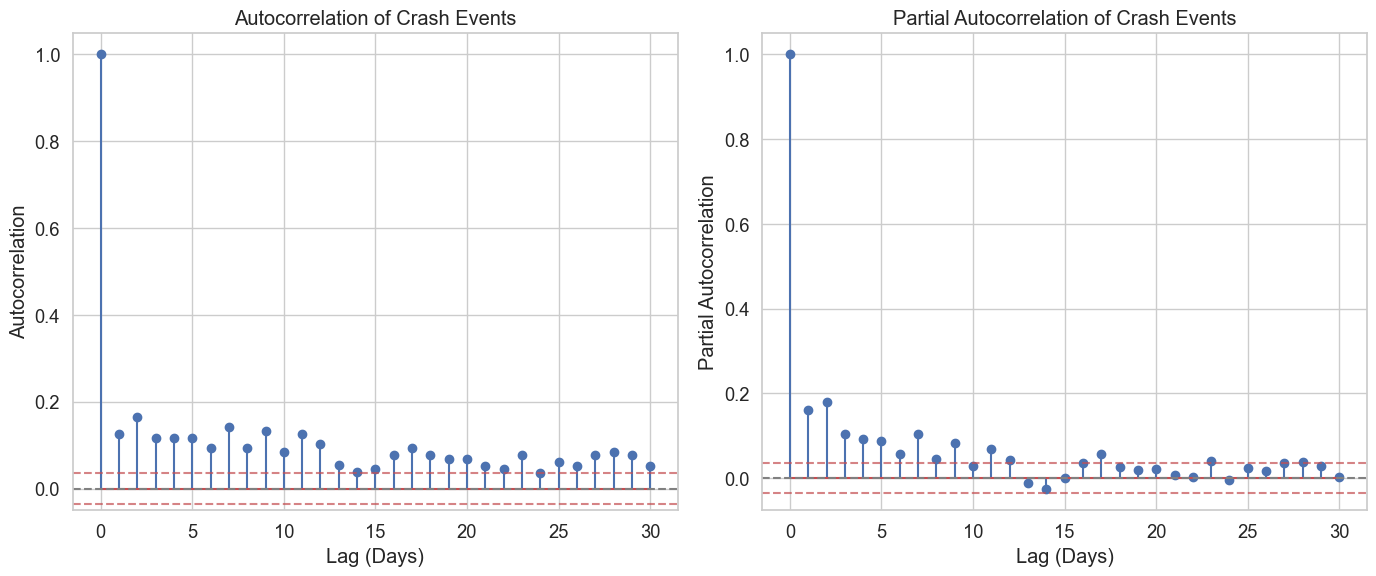

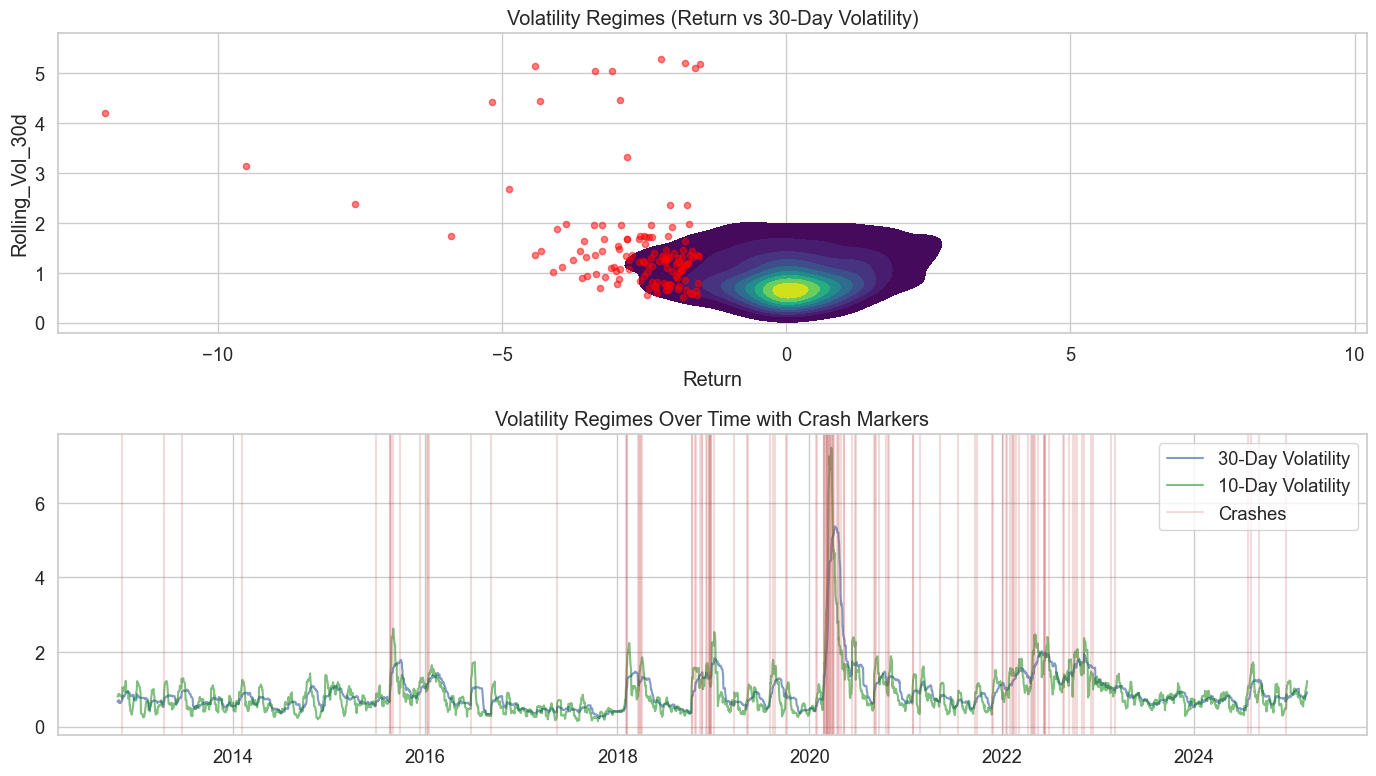

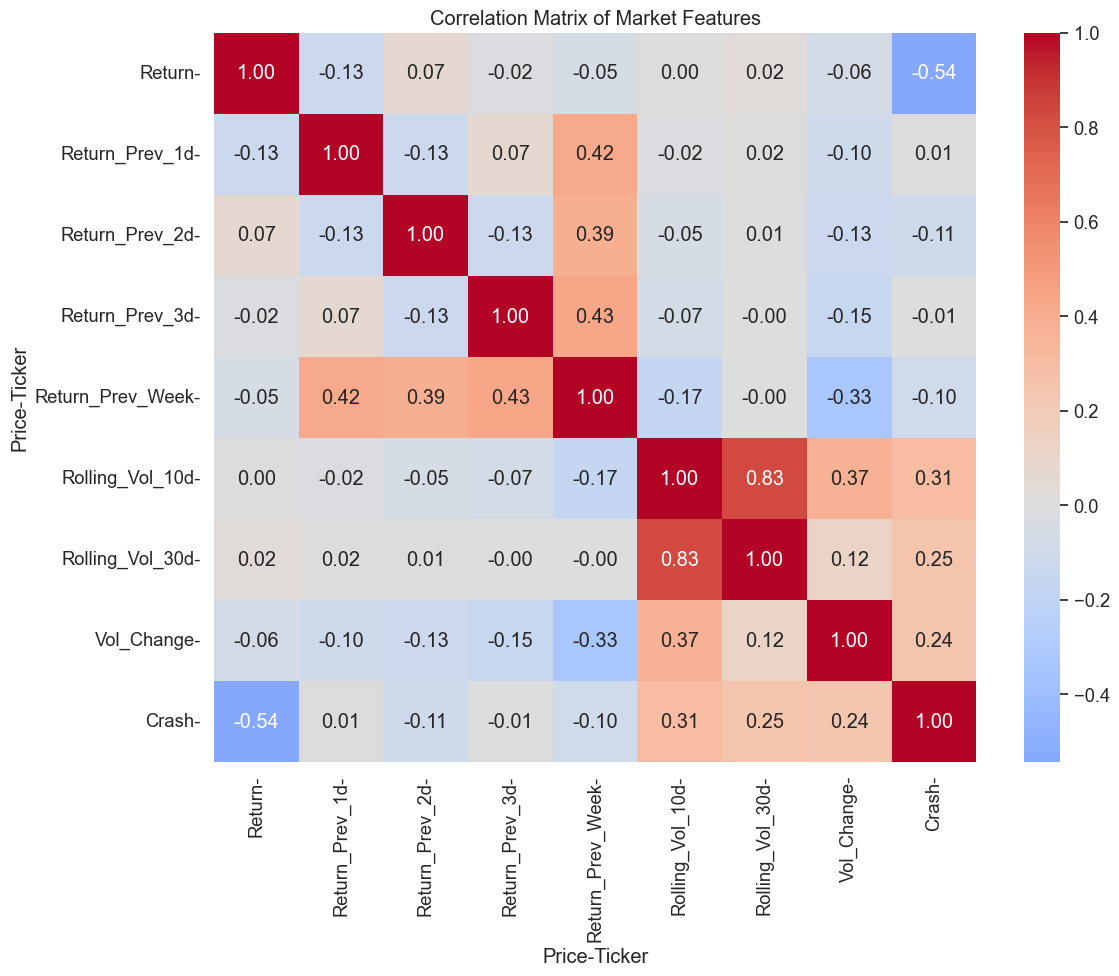

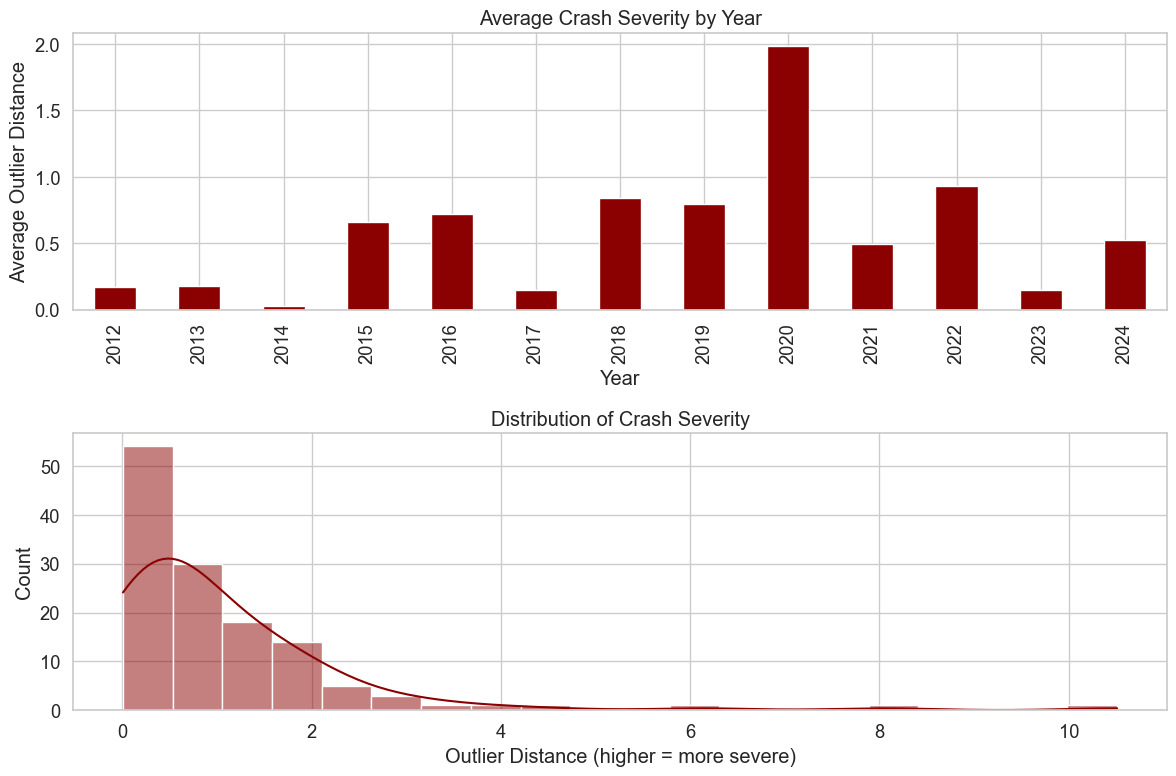

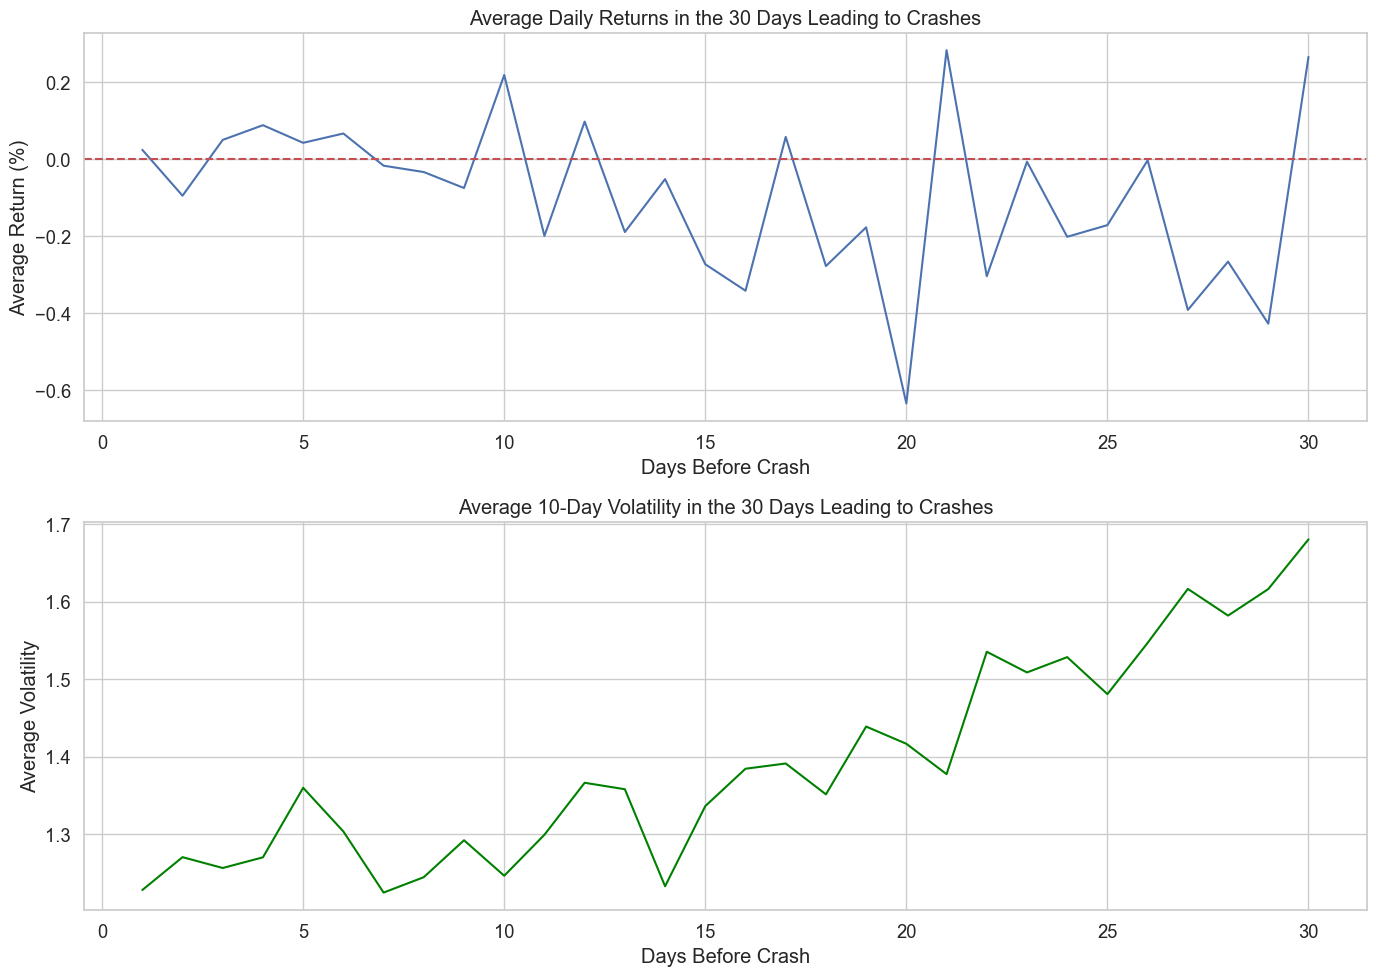

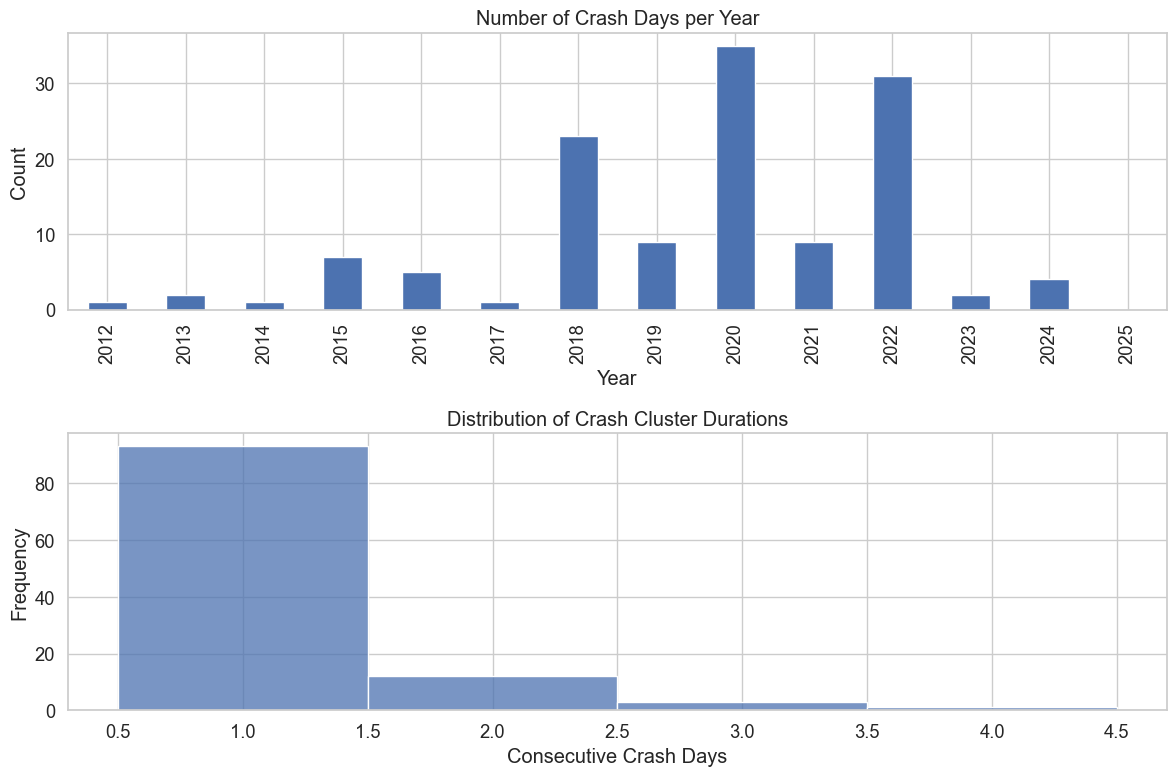

In [34]:
eda(detection_method='boxplot')

[*********************100%***********************]  1 of 1 completed

Analyzing ^GSPC from 2005-07-22 to 2025-04-08
Using std_dev method for crash detection
Starting Exploratory Data Analysis...
Data ranges from 2012-10-19 to 2025-03-07
Total days: 3112



--- SUMMARY STATISTICS ---

Return Statistics:
Price    Return Log_Return Weekly_Return Monthly_Return
Ticker                                                 
count   3112.00    3112.00       3112.00        3112.00
mean       0.05       0.04          0.25           1.05
std        1.06       1.06          2.18           4.19
min      -11.98     -12.77        -17.97         -32.97
25%       -0.37      -0.37         -0.69          -0.86
50%        0.07       0.07          0.40           1.51
75%        0.56       0.56          1.41           3.46
max        9.38       8.97         17.40          25.11

Crash Statistics:
Total crash days: 49
Percentage of crash days: 1.57%
Average return on crash days: -3.72%
Average volatility on crash days: 1.9205
Average days between crashes: 53.7
Median days between crashes: 9.0

EDA complete! All plots saved to 'eda_plots' directory.
Processed data saved to 'market_data_with_crashes.csv'


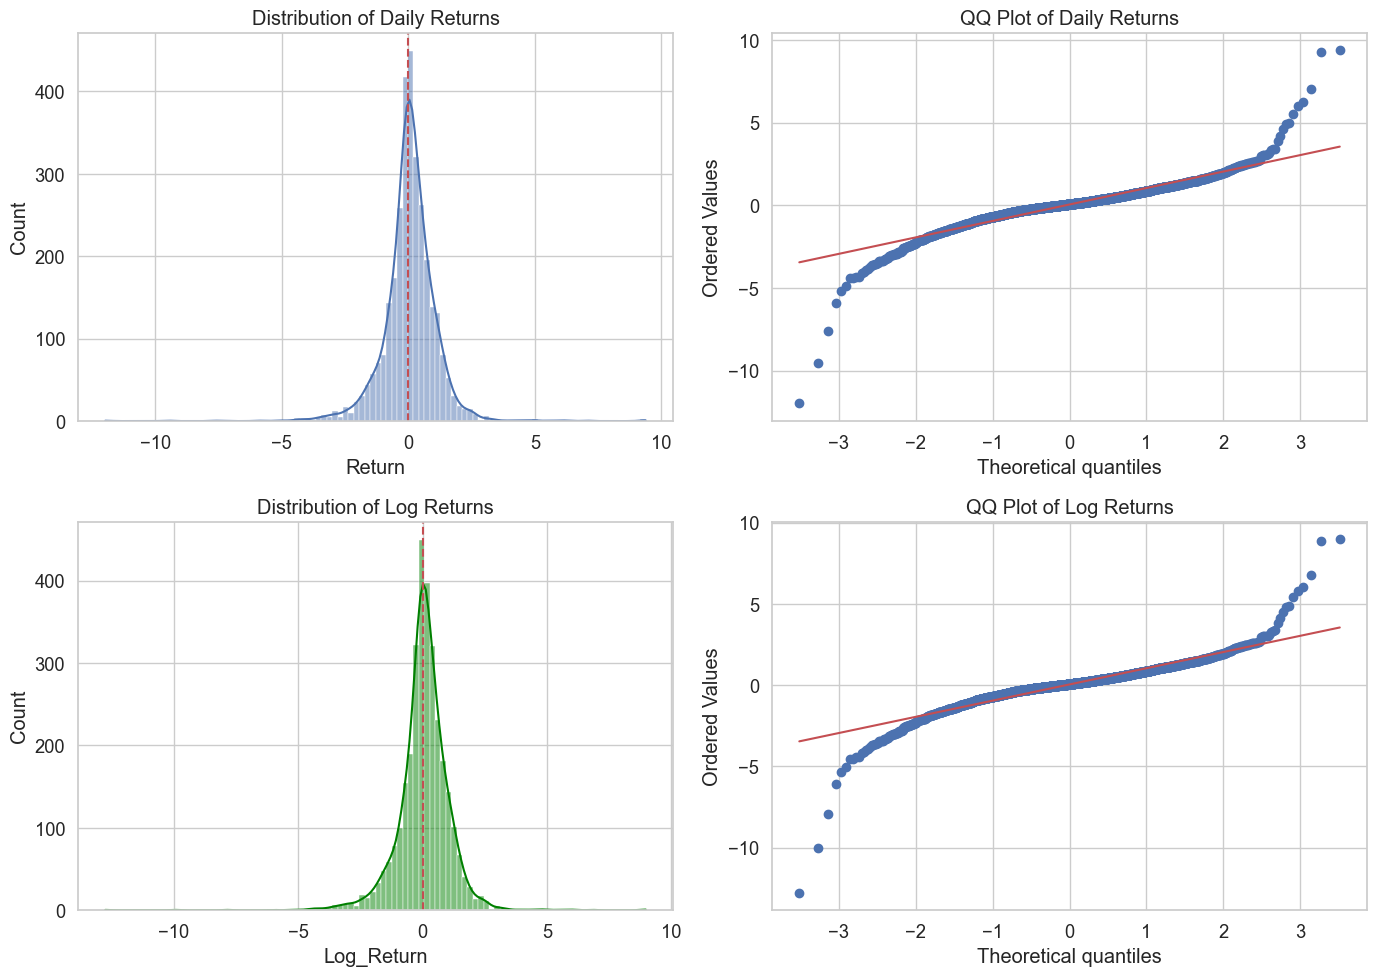

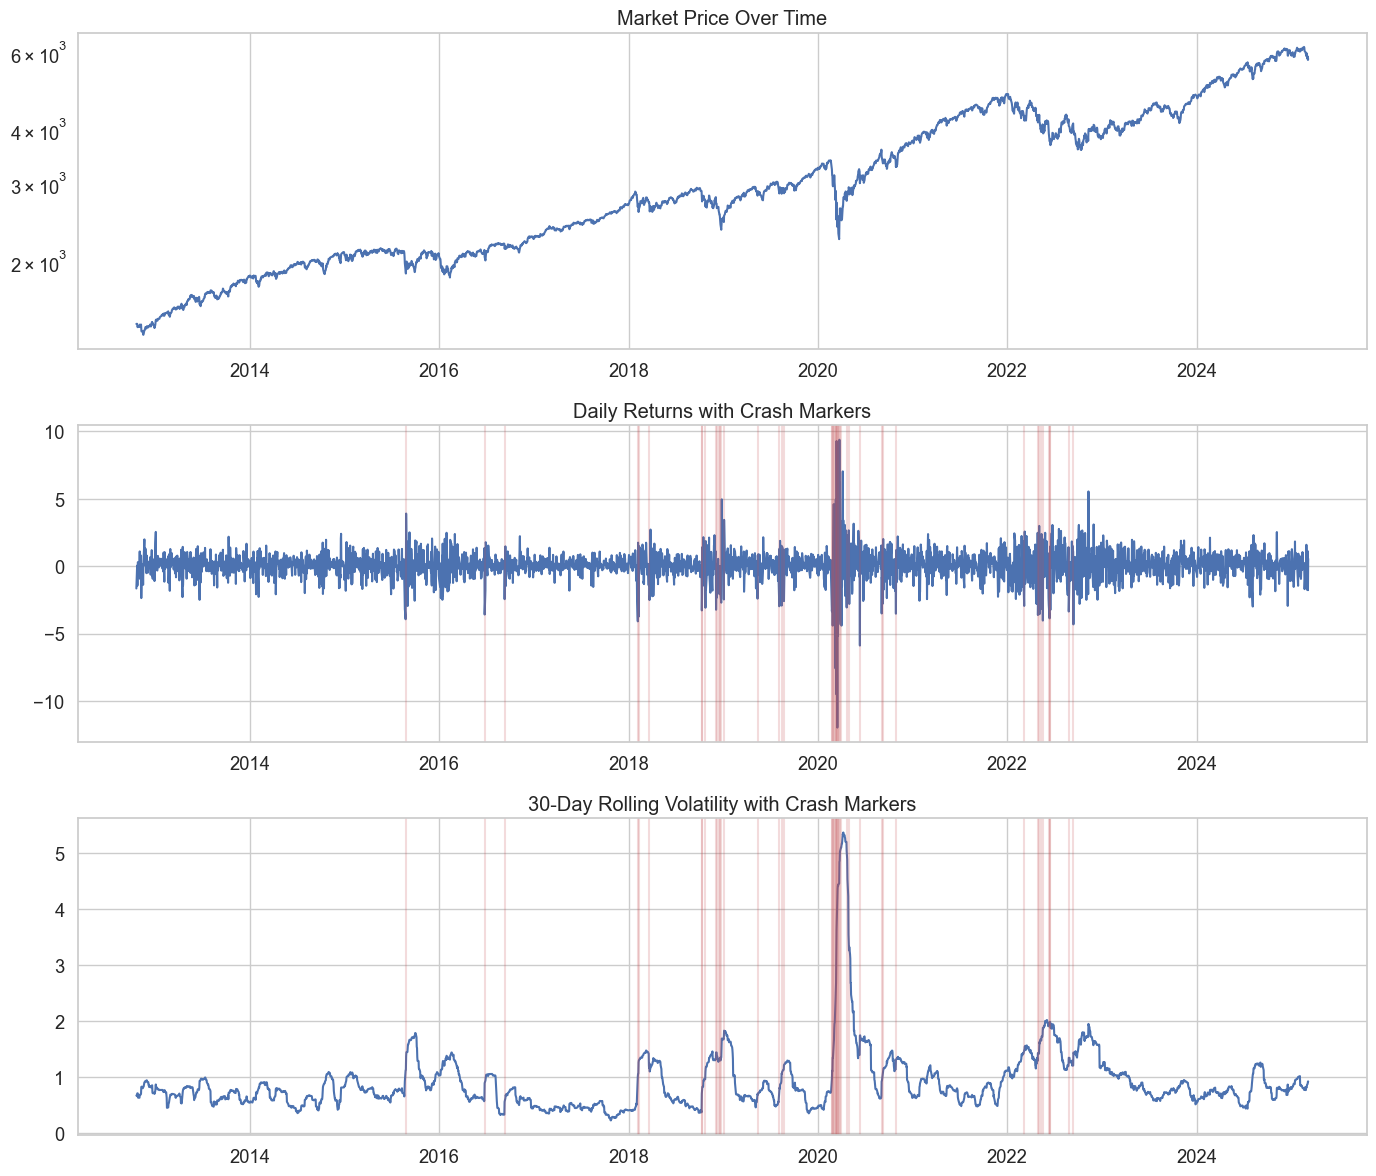

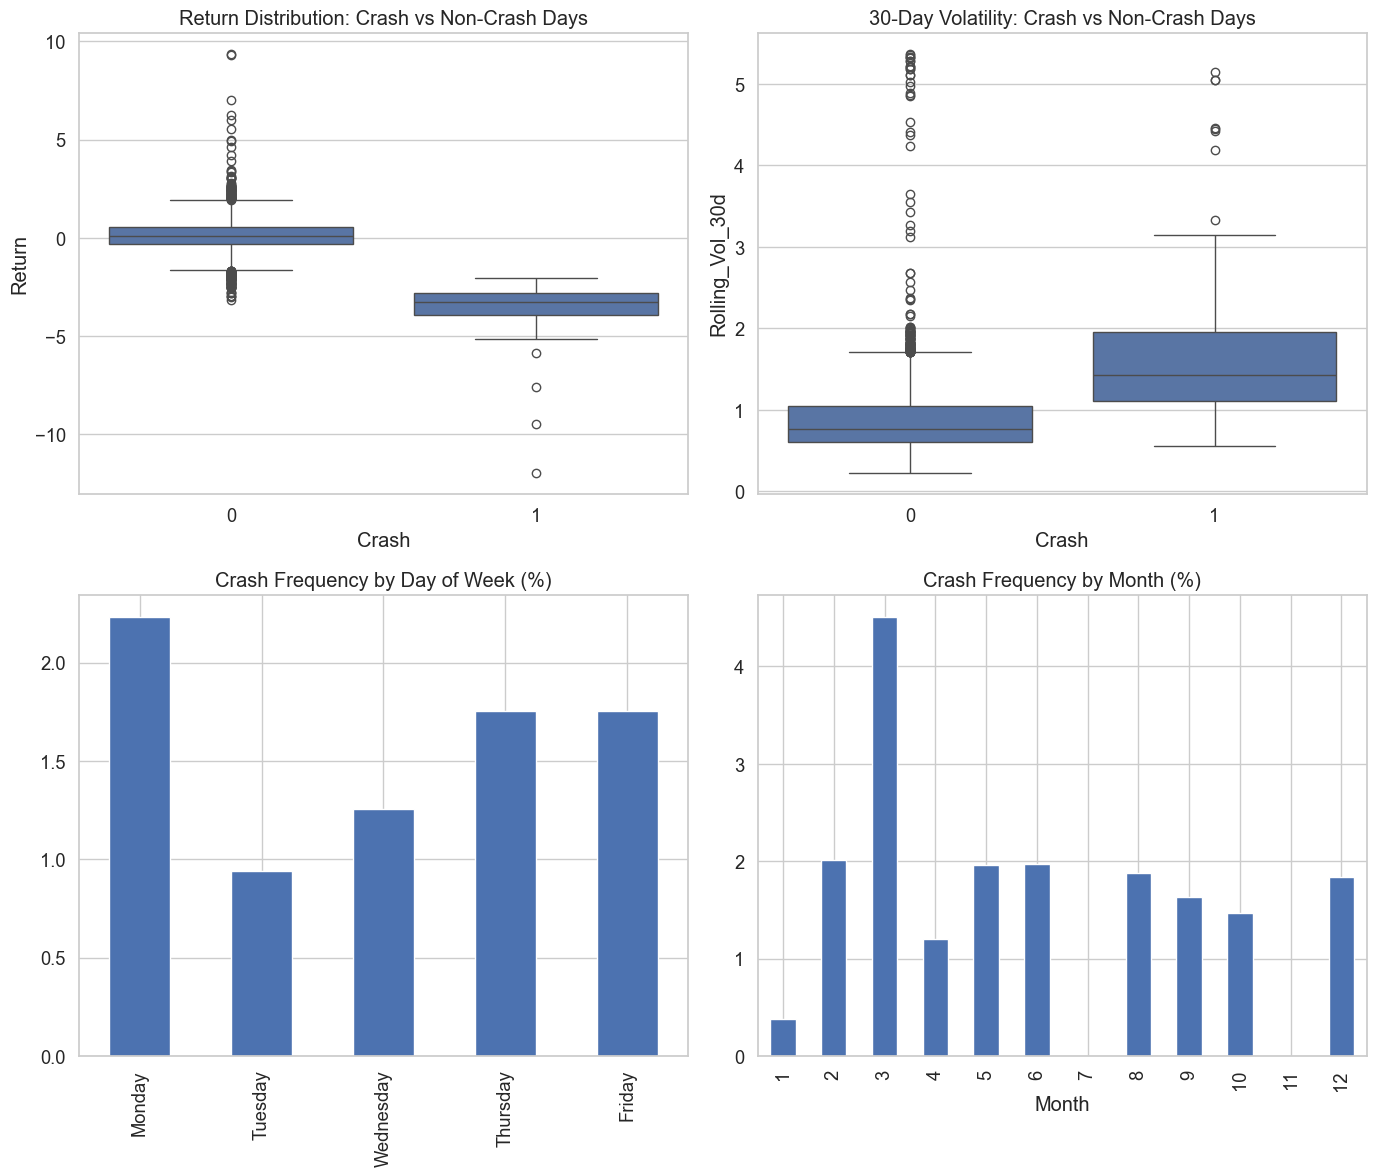

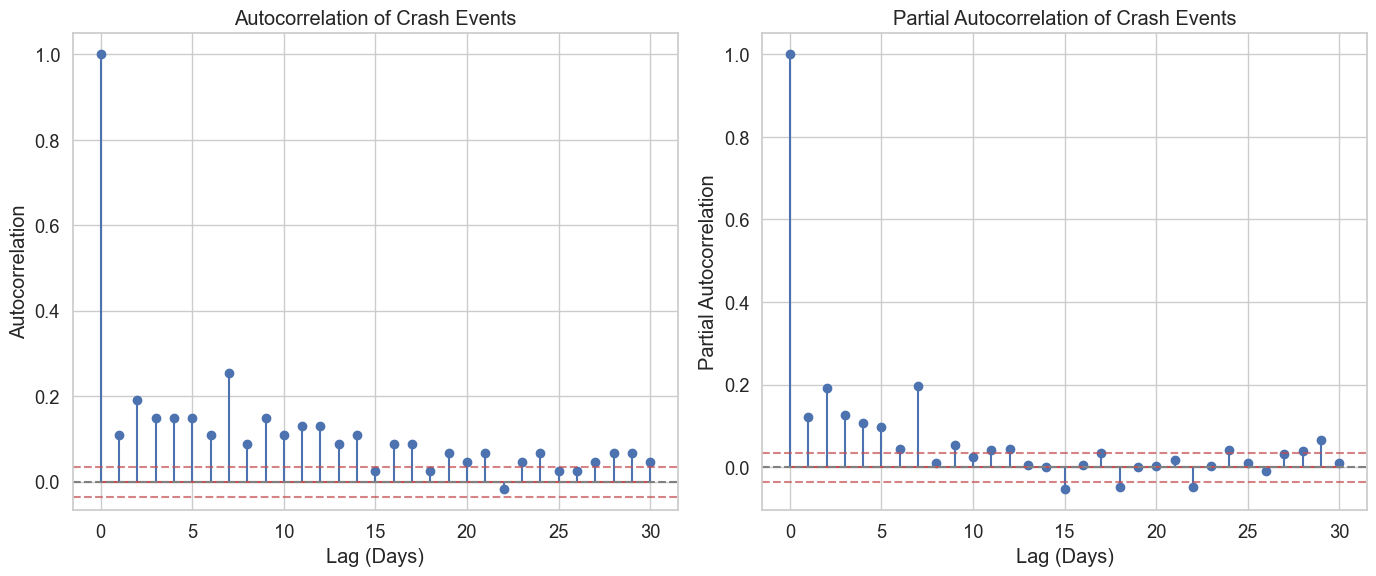

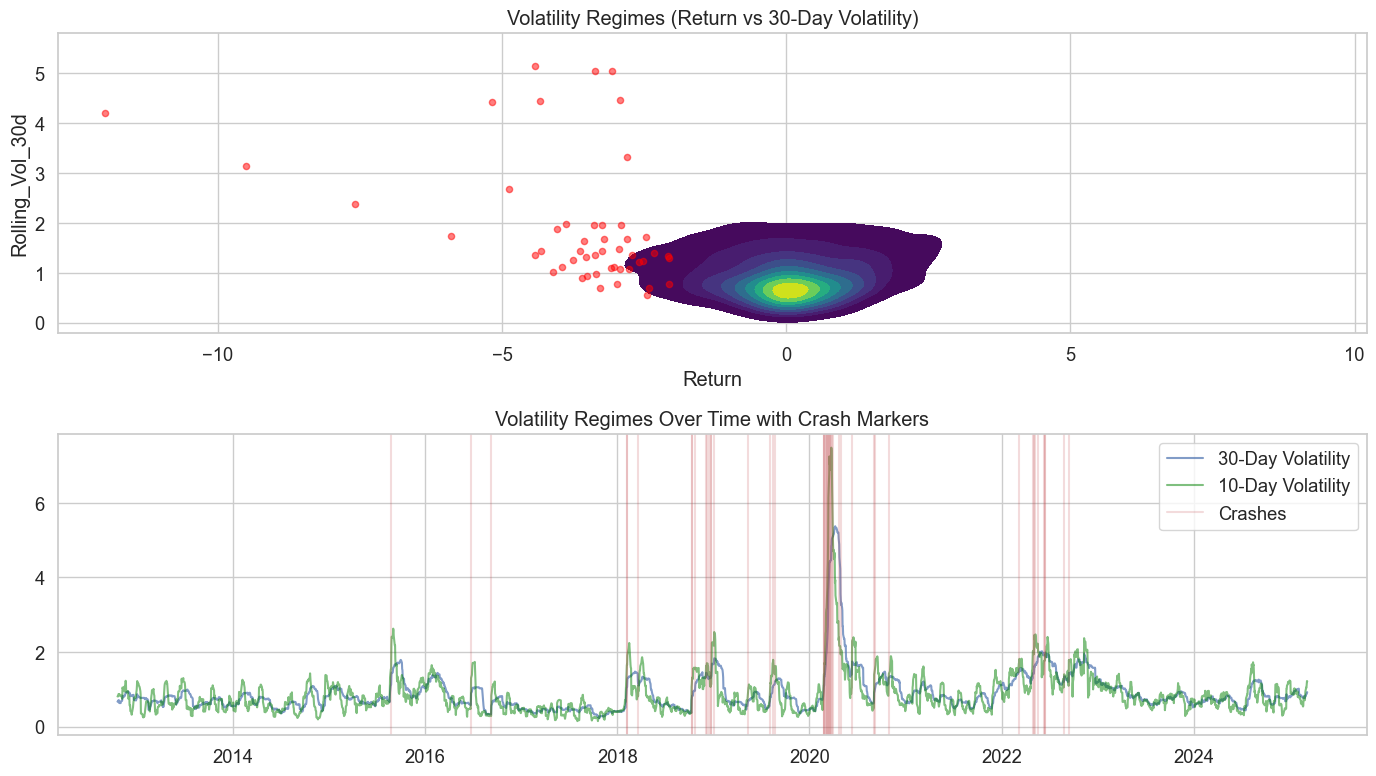

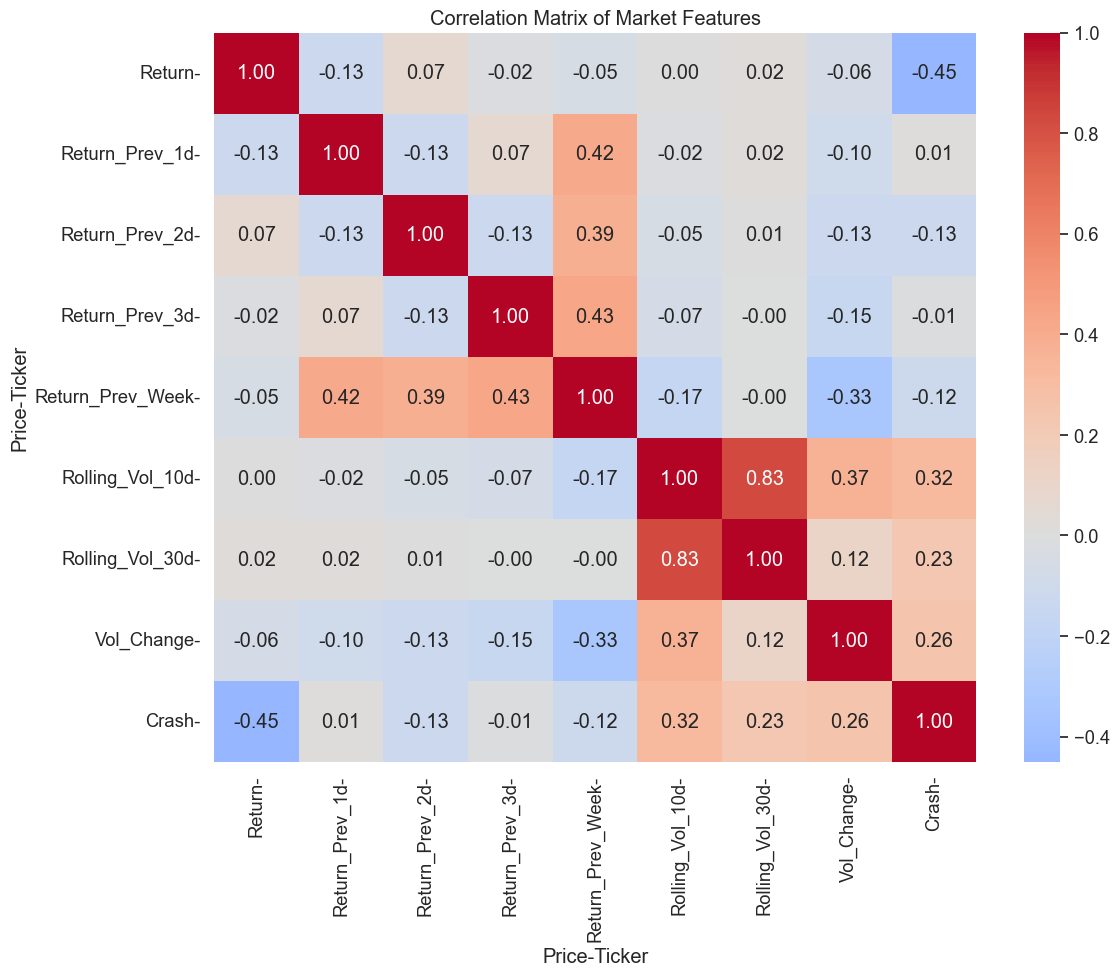

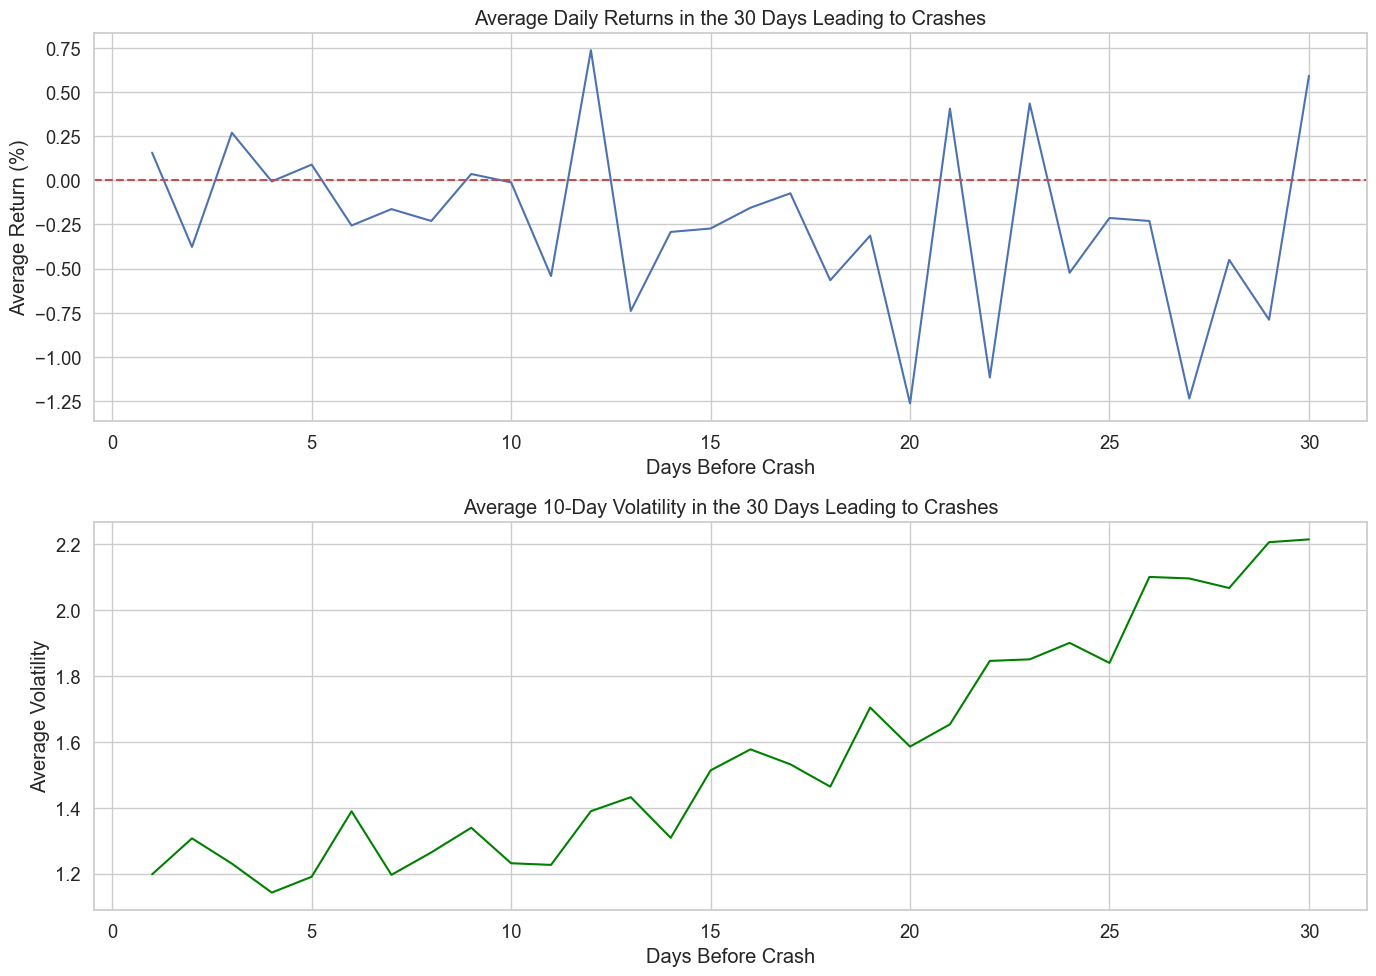

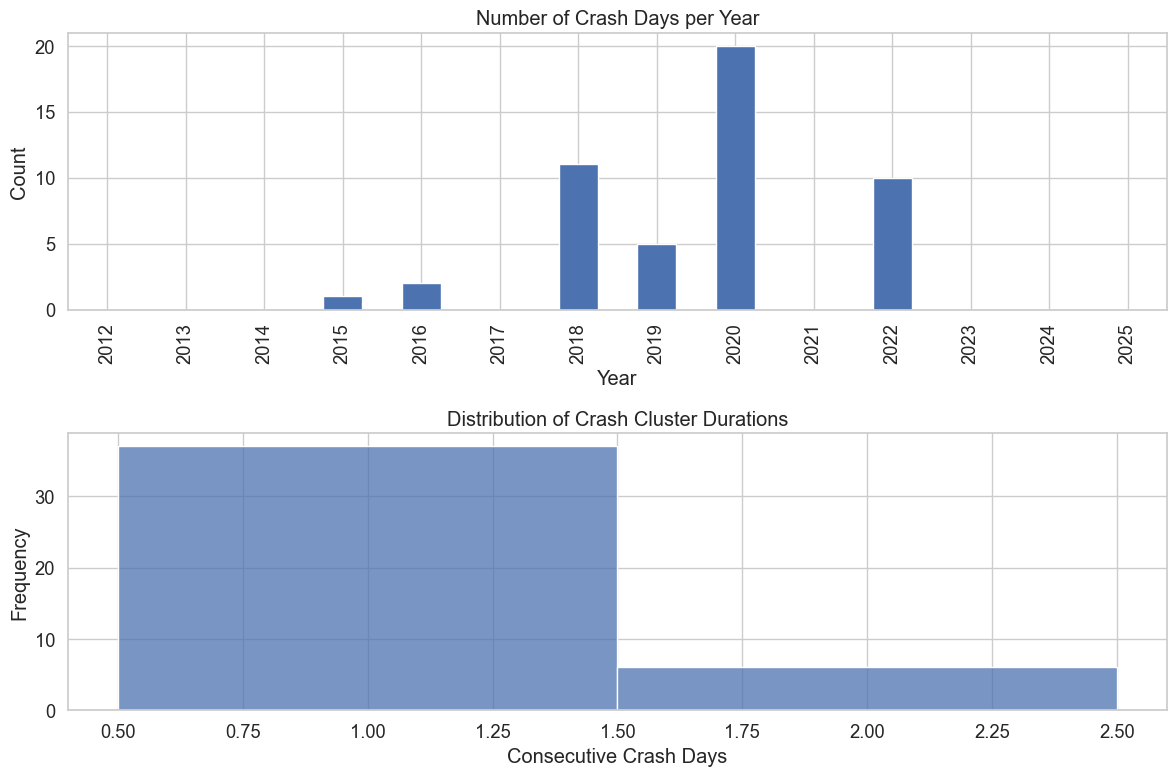

In [35]:
eda(detection_method='std_dev')

## **MODELLING** 

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Step 1: Download historical market data
def download_market_data(ticker, start_date, end_date):
    """Download market data from Yahoo Finance."""
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Step 2: Calculate returns
def calculate_returns(data):
    """Calculate percentage returns from price data using Close prices."""
    data['Return'] = data['Close'].pct_change() * 100
    return data.dropna()

# Step 3: Implement Le Bris' market crash detection method
def detect_crashes(data, lookback_period_years=7, method='std_dev', std_dev_threshold=-2.5):
    """
    Detect market crashes using either:
    1. Le Bris' rolling standard deviation methodology
    2. Boxplot outlier detection (Tukey's method)
    
    Parameters:
    -----------
    data : DataFrame
        DataFrame containing market data with 'Return' column
    lookback_period_years : int
        Number of years to look back for establishing the market context
    method : str
        'std_dev' for Le Bris' method or 'boxplot' for Tukey's boxplot method
    std_dev_threshold : float
        Threshold for standard deviation method (only used if method='std_dev')
        
    Returns:
    --------
    DataFrame with crash detection columns added
    """
    # Convert lookback period from years to trading days (approx 252 trading days per year)
    lookback_days = int(lookback_period_years * 252)
    
    if method == 'std_dev':
        # Le Bris' method: Calculate rolling mean and standard deviation
        data['Rolling_Mean'] = data['Return'].rolling(window=lookback_days).mean()
        data['Rolling_Std'] = data['Return'].rolling(window=lookback_days).std()
        
        # Calculate adjusted returns (in terms of standard deviations)
        data['Adjusted_Return'] = (data['Return'] - data['Rolling_Mean']) / data['Rolling_Std']
        
    elif method == 'boxplot':
        # Boxplot method using rolling windows
        def rolling_boxplot_stats(x):
            q1 = np.percentile(x, 25)
            q3 = np.percentile(x, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            return lower_bound
        
        # Calculate the lower bound of boxplot for each rolling window
        data['Boxplot_Lower_Bound'] = data['Return'].rolling(window=lookback_days).apply(
            rolling_boxplot_stats, raw=True
        )
        
        # Calculate how far each return is below the lower bound (positive = below bound)
        data['Boxplot_Outlier_Distance'] = data['Boxplot_Lower_Bound'] - data['Return']
        data.loc[data['Boxplot_Outlier_Distance'] <= 0, 'Boxplot_Outlier_Distance'] = 0
        
        # For compatibility, also calculate the adjusted return as in Le Bris method
        data['Rolling_Mean'] = data['Return'].rolling(window=lookback_days).mean()
        data['Rolling_Std'] = data['Return'].rolling(window=lookback_days).std()
        data['Adjusted_Return'] = (data['Return'] - data['Rolling_Mean']) / data['Rolling_Std']
    
    return data.dropna()

# Step 4: Label the crashes
def label_crashes(data, method='std_dev', threshold=-2.5):
    """
    Label crashes based on the detection method chosen.
    
    Parameters:
    -----------
    data : DataFrame
        DataFrame with crash detection metrics
    method : str
        'std_dev' for standard deviation based or 'boxplot' for boxplot outlier based
    threshold : float
        For std_dev: threshold in standard deviations
        For boxplot: not used (outliers already defined by Tukey's method)
    """
    data['Crash'] = 0
    
    if method == 'std_dev':
        # Label crashes using standard deviation approach
        data.loc[data['Adjusted_Return'] < threshold, 'Crash'] = 1
    elif method == 'boxplot':
        # Label crashes using boxplot approach - any outlier below lower bound
        data.loc[data['Boxplot_Outlier_Distance'] > 0, 'Crash'] = 1
    
    # Also create a forward-looking crash indicator for prediction purposes
    data['Crash_Next_Month'] = data['Crash'].shift(-21)  # ~21 trading days in a month
    
    return data.dropna()

# Step 5: Create features for prediction
def create_features(data, lookback_days=63):  # ~3 months
    """Create features for crash prediction model."""
    # Recent volatility
    data['Volatility_3M'] = data['Return'].rolling(lookback_days).std()
    
    # Trend features
    data['Return_1M'] = data['Return'].rolling(21).sum()
    data['Return_3M'] = data['Return'].rolling(63).sum()
    data['Return_6M'] = data['Return'].rolling(126).sum()
    
    # Price relative to moving averages
    data['Price_Rel_50MA'] = data['Close'] / data['Close'].rolling(50).mean() - 1
    data['Price_Rel_200MA'] = data['Close'] / data['Close'].rolling(200).mean() - 1
    
    # Trading volume features
    data['Volume_Change'] = data['Volume'].pct_change()
    data['Volume_Rel_3M'] = data['Volume'] / data['Volume'].rolling(63).mean()
    
    return data.dropna()

# Step 6: Implement advanced modeling approaches
def build_advanced_models(data):
    """
    Build multiple advanced models to predict market crashes:
    1. Anomaly detection approach (isolation forest, one-class SVM)
    2. Time series models (ARIMA-based features)
    3. Cost-sensitive learning
    """
    # Define features and target
    features = [
        'Volatility_3M', 'Return_1M', 'Return_3M', 'Return_6M',
        'Price_Rel_50MA', 'Price_Rel_200MA', 'Volume_Change', 'Volume_Rel_3M'
    ]
    
    X = data[features]
    y = data['Crash_Next_Month']
    
    # Check class imbalance
    crash_ratio = y.mean()
    print(f"Class imbalance: {crash_ratio:.4f} (proportion of crash days)")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)
    
    results = {}
    
    # 1. ANOMALY DETECTION APPROACHES
    print("\n=== ANOMALY DETECTION MODELS ===")
    
    # 1.1 Isolation Forest
    print("\nIsolation Forest:")
    iso_forest = IsolationForest(contamination=crash_ratio, random_state=42)
    # Fit model on non-crash data only
    iso_forest.fit(X_train[y_train == 0])
    
    # Predict anomalies
    y_pred_iso = iso_forest.predict(X_test)
    # Convert output: -1 for anomaly (crash), 1 for normal (no crash) -> transform to 1 for crash, 0 for no crash
    y_pred_iso = np.where(y_pred_iso == -1, 1, 0)
    
    print(classification_report(y_test, y_pred_iso, zero_division=0))
    results['Isolation Forest'] = {
        'y_true': y_test,
        'y_pred': y_pred_iso
    }
    
    # 1.2 One-Class SVM
    print("\nOne-Class SVM:")
    oc_svm = OneClassSVM(nu=crash_ratio * 2, kernel='rbf', gamma='auto')  # nu is upper bound on fraction of outliers
    oc_svm.fit(X_train[y_train == 0])
    
    y_pred_svm = oc_svm.predict(X_test)
    y_pred_svm = np.where(y_pred_svm == -1, 1, 0)
    
    print(classification_report(y_test, y_pred_svm, zero_division=0))
    results['One-Class SVM'] = {
        'y_true': y_test,
        'y_pred': y_pred_svm
    }
    
    # 1.3 Local Outlier Factor
    print("\nLocal Outlier Factor:")
    lof = LocalOutlierFactor(n_neighbors=20, contamination=crash_ratio)
    # LOF doesn't have a proper predict method, so we use fit_predict directly
    # For training data, get predicted labels
    y_train_lof = np.where(lof.fit_predict(X_train) == -1, 1, 0)
    
    # For test data, use a separate LOF instance
    lof_test = LocalOutlierFactor(n_neighbors=20, contamination=crash_ratio)
    y_pred_lof = np.where(lof_test.fit_predict(X_test) == -1, 1, 0)
    
    print(classification_report(y_test, y_pred_lof, zero_division=0))
    results['Local Outlier Factor'] = {
        'y_true': y_test,
        'y_pred': y_pred_lof
    }
    
    # 2. TIME SERIES-SPECIFIC APPROACH
    print("\n=== TIME SERIES APPROACH ===")
    
    # Add time series features: recent volatility trends, change in volatility
    # We'll use the original data for this since we need the time aspect
    
    # Train a more sophisticated model with additional time-based features
    # For demonstration, we'll use XGBoost with temporal features
    
    # Create temporal features
    data_temp = data.copy()
    
    # Volatility changes
    data_temp['Vol_Change_1M'] = data_temp['Volatility_3M'].pct_change(20)  # 1 month volatility change
    data_temp['Vol_Change_3M'] = data_temp['Volatility_3M'].pct_change(60)  # 3 month volatility change
    
    # Add day of week, month, quarter features
    data_temp['DayOfWeek'] = data_temp.index.dayofweek
    data_temp['Month'] = data_temp.index.month
    data_temp['Quarter'] = data_temp.index.quarter
    
    # Momentum features
    data_temp['RSI_14'] = calculate_rsi(data_temp['Close'], window=14)
    
    # Calculate rate of change of various indicators
    data_temp['ROC_Price_50'] = calculate_rate_of_change(data_temp['Price_Rel_50MA'], 10)
    data_temp['ROC_Volume'] = calculate_rate_of_change(data_temp['Volume'], 10)
    
    # Drop NaN values
    data_temp = data_temp.dropna()
    
    # Define time-based features
    ts_features = features + [
        'Vol_Change_1M', 'Vol_Change_3M', 'DayOfWeek', 'Month', 'Quarter',
        'RSI_14', 'ROC_Price_50', 'ROC_Volume'
    ]
    
    X_ts = data_temp[ts_features]
    y_ts = data_temp['Crash_Next_Month']
    
    # Standardize
    X_ts_scaled = scaler.fit_transform(X_ts)
    X_ts_scaled_df = pd.DataFrame(X_ts_scaled, index=X_ts.index, columns=X_ts.columns)
    
    # Split with respect to time (no shuffling)
    train_size = int(len(X_ts_scaled_df) * 0.8)
    X_ts_train = X_ts_scaled_df.iloc[:train_size]
    X_ts_test = X_ts_scaled_df.iloc[train_size:]
    y_ts_train = y_ts.iloc[:train_size]
    y_ts_test = y_ts.iloc[train_size:]
    
    print("\nXGBoost with Time-Based Features:")
    # Use scale_pos_weight for class imbalance
    scale_weight = (y_ts_train == 0).sum() / (y_ts_train == 1).sum()
    
    xgb_model = XGBClassifier(
        scale_pos_weight=scale_weight,
        learning_rate=0.01,
        n_estimators=200,
        max_depth=4,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    xgb_model.fit(X_ts_train, y_ts_train)
    y_pred_xgb = xgb_model.predict(X_ts_test)
    
    print(classification_report(y_ts_test, y_pred_xgb, zero_division=0))
    results['XGBoost Time Series'] = {
        'y_true': y_ts_test,
        'y_pred': y_pred_xgb,
        'feature_importance': pd.DataFrame({
            'Feature': X_ts.columns,
            'Importance': xgb_model.feature_importances_
        }).sort_values('Importance', ascending=False)
    }
    
    # 3. COST-SENSITIVE LEARNING
    print("\n=== COST-SENSITIVE LEARNING ===")
    
    # Use the original features but with cost-sensitive learning
    X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)
    
    # 3.1 Random Forest with class weights
    print("\nRandom Forest with Custom Class Weights:")
    rf_cost = RandomForestClassifier(
        n_estimators=200,
        max_depth=5,
        min_samples_leaf=10,
        class_weight={0:1, 1:100},  # High penalty for missing crashes
        random_state=42
    )
    
    rf_cost.fit(X_train, y_train)
    y_pred_rf_cost = rf_cost.predict(X_test)
    
    print(classification_report(y_test, y_pred_rf_cost, zero_division=0))
    results['Random Forest Cost-Sensitive'] = {
        'y_true': y_test,
        'y_pred': y_pred_rf_cost,
        'feature_importance': pd.DataFrame({
            'Feature': X.columns,
            'Importance': rf_cost.feature_importances_
        }).sort_values('Importance', ascending=False)
    }
    
    # 3.2 XGBoost with custom objective and scale_pos_weight
    print("\nXGBoost with Custom Weights:")
    xgb_cost = XGBClassifier(
        scale_pos_weight=scale_weight * 10,  # Even higher weight for positive class
        learning_rate=0.01,
        n_estimators=200,
        max_depth=4,
        random_state=42
    )
    
    xgb_cost.fit(X_train, y_train)
    y_pred_xgb_cost = xgb_cost.predict(X_test)
    
    print(classification_report(y_test, y_pred_xgb_cost, zero_division=0))
    results['XGBoost Cost-Sensitive'] = {
        'y_true': y_test,
        'y_pred': y_pred_xgb_cost,
        'feature_importance': pd.DataFrame({
            'Feature': X.columns,
            'Importance': xgb_cost.feature_importances_
        }).sort_values('Importance', ascending=False)
    }
    
    # Evaluate and compare all models
    print("\n=== MODEL COMPARISON ===")
    for model_name, result in results.items():
        if 'y_true' in result and 'y_pred' in result:
            tn, fp, fn, tp = confusion_matrix(result['y_true'], result['y_pred']).ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            print(f"{model_name}:")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1 Score: {f1:.4f}")
            print(f"  True Positives (correctly predicted crashes): {tp}")
            print(f"  False Negatives (missed crashes): {fn}")
            print(f"  False Positives (false alarms): {fp}")
            print()
    
    # Find the best model
    best_model = max(results.items(), key=lambda x: 
                    (confusion_matrix(x[1]['y_true'], x[1]['y_pred']).ravel()[3]) # maximize TP
                    if 'y_true' in x[1] and 'y_pred' in x[1] else (0, "")
                )[0]
    
    print(f"Recommended model: {best_model} (best at detecting actual crashes)")
    
    return results


# Helper functions for time series features
def calculate_rsi(prices, window=14):
    """Calculate Relative Strength Index."""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_rate_of_change(series, window=10):
    """Calculate the rate of change over a specified window."""
    return series.pct_change(window) * 100

# Step 7: Visualize results
def visualize_advanced_results(data, results):
    """Create visualizations of model performance and crash detection results."""
    # Plot 1: Compare model performance
    plt.figure(figsize=(12, 8))
    
    # Prepare metrics for plotting
    models = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    TP_counts = []
    
    for model_name, result in results.items():
        if 'y_true' in result and 'y_pred' in result:
            tn, fp, fn, tp = confusion_matrix(result['y_true'], result['y_pred']).ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            models.append(model_name)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            TP_counts.append(tp)
    
    # Create grouped bar chart
    x = np.arange(len(models))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.bar(x - width, precision_scores, width, label='Precision', color='blue', alpha=0.7)
    ax.bar(x, recall_scores, width, label='Recall', color='green', alpha=0.7)
    ax.bar(x + width, f1_scores, width, label='F1 Score', color='red', alpha=0.7)
    
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_ylim(0, 1.0)
    ax.set_title('Model Performance Comparison')
    ax.set_ylabel('Score')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    
    # Plot 2: True Positives by model (actual crashes detected)
    plt.figure(figsize=(12, 6))
    plt.bar(models, TP_counts, color='purple', alpha=0.7)
    plt.title('Number of Actual Crashes Detected by Each Model')
    plt.xlabel('Model')
    plt.ylabel('True Positives (Detected Crashes)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('crash_detection_comparison.png')
    
    # Plot 3: Feature importance for the best model (if available)
    best_model = max(results.items(), key=lambda x: 
                     (confusion_matrix(x[1]['y_true'], x[1]['y_pred']).ravel()[3]) # maximize TP 
                     if 'y_true' in x[1] and 'y_pred' in x[1] else (0, "")
                    )[0]
    
    if 'feature_importance' in results[best_model]:
        plt.figure(figsize=(10, 8))
        feat_imp = results[best_model]['feature_importance']
        
        # Get top 15 features for clarity
        features = list(feat_imp['Feature'])
        importances = list(feat_imp['Importance'])
        
        # Sort for visualization
        sorted_idx = np.argsort(importances)
        sorted_features = [features[i] for i in sorted_idx[-15:]]  # Get the top 15
        sorted_importances = [importances[i] for i in sorted_idx[-15:]]
        
        # Create plot directly with matplotlib to avoid any DataFrame/MultiIndex issues
        plt.barh(range(len(sorted_features)), sorted_importances)
        plt.yticks(range(len(sorted_features)), sorted_features)
        plt.xlabel('Importance')
        plt.title(f'Top Features for {best_model}')
        plt.tight_layout()
        plt.savefig('best_model_features.png')
    
    # Plot 4: Timeline of actual vs predicted crashes for best model
    if 'y_true' in results[best_model] and 'y_pred' in results[best_model]:
        y_true = results[best_model]['y_true']
        y_pred = results[best_model]['y_pred']
        
        # Get the dates from y_true
        crash_dates = y_true.index[y_true == 1]
        predicted_crash_dates = y_true.index[y_pred == 1]
        
        plt.figure(figsize=(16, 6))
        
        # Plot the adjusted returns from the original data to show market context
        plt.plot(data.loc[y_true.index, 'Adjusted_Return'], 
                 color='gray', alpha=0.5, label='Adjusted Returns')
        
        # Mark actual crashes
        for date in crash_dates:
            plt.axvline(x=date, color='red', alpha=0.3, linestyle='-')
        
        # Mark predicted crashes with different color
        for date in predicted_crash_dates:
            plt.axvline(x=date, color='blue', alpha=0.3, linestyle='--')
        
        # Add a legend item for actual crash dates
        plt.axvline(x=crash_dates[0] if len(crash_dates) > 0 else y_true.index[0], 
                    color='red', alpha=0.7, label='Actual Crash')
        
        # Add a legend item for predicted crash dates
        plt.axvline(x=predicted_crash_dates[0] if len(predicted_crash_dates) > 0 else y_true.index[0], 
                    color='blue', alpha=0.7, linestyle='--', label='Predicted Crash')
        
        plt.title(f'Timeline of Actual vs Predicted Crashes ({best_model})')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Return (σ)')
        plt.legend()
        plt.tight_layout()
        plt.savefig('crash_prediction_timeline.png')
        
    # Plot 5: Confusion matrices for all models
    n_models = len(models)
    fig, axs = plt.subplots(int(np.ceil(n_models/2)), 2, figsize=(16, 4*int(np.ceil(n_models/2))))
    axs = axs.flatten()
    
    for i, model_name in enumerate(models):
        if i < len(axs):
            cm = confusion_matrix(results[model_name]['y_true'], results[model_name]['y_pred'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[i],
                        xticklabels=['No Crash', 'Crash'],
                        yticklabels=['No Crash', 'Crash'])
            axs[i].set_title(f'Confusion Matrix - {model_name}')
            axs[i].set_xlabel('Predicted')
            axs[i].set_ylabel('Actual')
    
    # Hide any unused subplots
    for i in range(len(models), len(axs)):
        fig.delaxes(axs[i])
        
    plt.tight_layout()
    plt.savefig('confusion_matrices.png')

def modelling(detection_method='boxplot', std_dev_threshold=-2.5, ticker='^GSPC'):
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=30*12*20)).strftime('%Y-%m-%d')  # 20 years
    
    
    print(f"Analyzing {ticker} from {start_date} to {end_date}")
    print(f"Using {detection_method} method for crash detection")
    if detection_method == 'std_dev':
        print(f"Standard deviation threshold: {std_dev_threshold}")
    else:
        print("Using Tukey's boxplot outlier detection (Q1 - 1.5*IQR)")
    
    # Download and process data
    data = download_market_data(ticker, start_date, end_date)
    data = calculate_returns(data)
    data = detect_crashes(data, method=detection_method, std_dev_threshold=std_dev_threshold)
    data = label_crashes(data, method=detection_method, threshold=std_dev_threshold)
    data = create_features(data)
    
    # Check how many crashes were detected
    crash_count = data['Crash'].sum()
    print(f"Detected {crash_count} market crashes")
    
    # Calculate percentage of days classified as crashes
    crash_percentage = (crash_count / len(data)) * 100
    print(f"Crash days: {crash_percentage:.2f}% of trading days")
    
    # List the top 10 crashes based on return magnitude
    if detection_method == 'std_dev':
        top_crashes = data[data['Crash'] == 1].sort_values('Adjusted_Return').head(10)
        print("\nTop 10 Detected Crashes (by standard deviation):")
        print(top_crashes[['Return', 'Adjusted_Return']].round(2))
    else:  # boxplot method
        top_crashes = data[data['Crash'] == 1].sort_values('Boxplot_Outlier_Distance', ascending=False).head(10)
        print("\nTop 10 Detected Crashes (by boxplot outlier distance):")
        print(top_crashes[['Return', 'Boxplot_Outlier_Distance']].round(2))
    
    # Build and evaluate advanced models
    results = build_advanced_models(data)
    
    # Visualize results
    visualize_advanced_results(data, results)
    
    print("\nAnalysis complete. Visualizations saved.")
    
    
    # Download and process data
    data = download_market_data(ticker, start_date, end_date)
    data = calculate_returns(data)
    data = detect_crashes(data)
    data = label_crashes(data)
    data = create_features(data)
    
    # Check how many crashes were detected
    crash_count = data['Crash'].sum()
    print(f"Detected {crash_count} market crashes")
    
    # List the top 10 crashes based on adjusted returns
    top_crashes = data[data['Crash'] == 1].sort_values('Adjusted_Return').head(10)
    print("\nTop 10 Detected Crashes:")
    print(top_crashes[['Return', 'Adjusted_Return']].round(2))
    
    # Build and evaluate prediction model
    model, X_test, y_test, y_pred = build_prediction_model(data)
    
    # Visualize results
    visualize_results(data, model, X_test, y_test, y_pred)
    
    print("\nAnalysis complete. Visualizations saved.")

[*********************100%***********************]  1 of 1 completed

Analyzing ^GSPC from 2005-07-22 to 2025-04-08
Using boxplot method for crash detection
Using Tukey's boxplot outlier detection (Q1 - 1.5*IQR)


Detected 128 market crashes
Crash days: 4.30% of trading days

Top 10 Detected Crashes (by boxplot outlier distance):
Price      Return Boxplot_Outlier_Distance
Ticker                                    
Date                                      
2020-03-16 -11.98                    10.51
2020-03-12  -9.51                     8.04
2020-03-09  -7.60                     6.13
2020-06-11  -5.89                     4.39
2020-03-18  -5.18                     3.71
2020-03-11  -4.89                     3.42
2020-02-27  -4.42                     2.96
2020-04-01  -4.41                     2.94
2020-03-20  -4.34                     2.86
2022-09-13  -4.32                     2.60
Class imbalance: 0.0440 (proportion of crash days)

=== ANOMALY DETECTION MODELS ===

Isolation Forest:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       569
         1.0       0.08      0.12      0.10        26

    accuracy                           0.91       595
 

[*********************100%***********************]  1 of 1 completed


Analysis complete. Visualizations saved.
Detected 49 market crashes

Top 10 Detected Crashes:
Price      Return Adjusted_Return
Ticker                           
Date                             
2020-03-16 -11.98          -12.31
2020-03-12  -9.51          -10.53
2020-03-09  -7.60           -8.86
2020-03-11  -4.89           -5.61
2020-02-27  -4.42           -5.42
2020-06-11  -5.89           -5.42
2020-03-18  -5.18           -5.25
2018-02-05  -4.10           -4.61
2020-03-20  -4.34           -4.37
2020-04-01  -4.41           -4.24
Class imbalance: 0.0171 (proportion of crash days)


Using probability threshold: 0.5000
Model Evaluation:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       585
         1.0       0.33      0.10      0.15        10

    accuracy                           0.98       595
   macro avg       0.66      0.55      0.57       595
weighted avg       0.97      0.98      0.98       595


Feature Importance:
           Feature  Importance
2        Return_3M    0.184557
0    Volatility_3M    0.151926
5  Price_Rel_200MA    0.130980
1        Return_1M    0.122662
3        Return_6M    0.115490
4   Price_Rel_50MA    0.102398
6    Volume_Change    0.097533
7    Volume_Rel_3M    0.094453

Analysis complete. Visualizations saved.


<Figure size 1200x800 with 0 Axes>

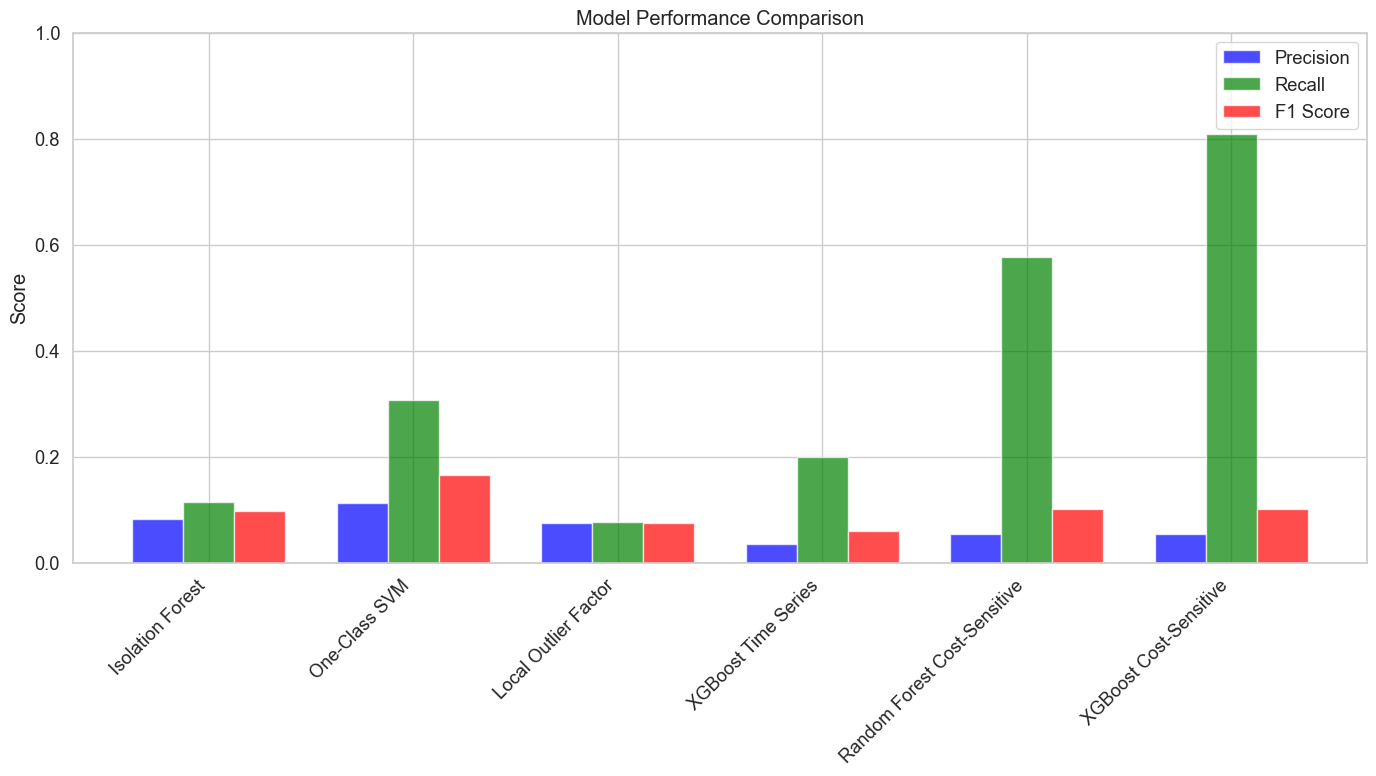

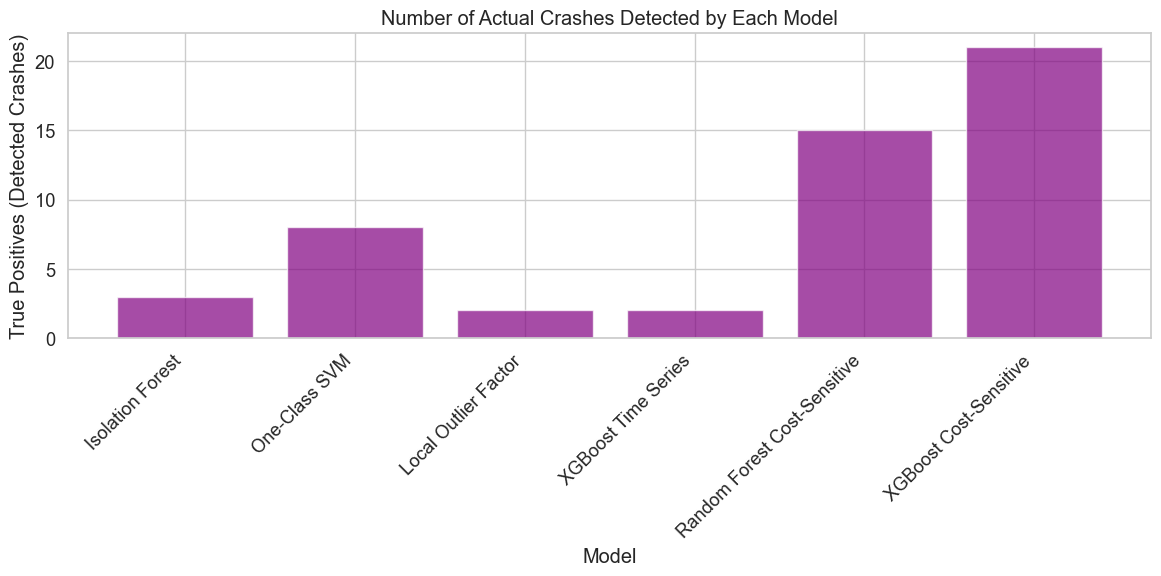

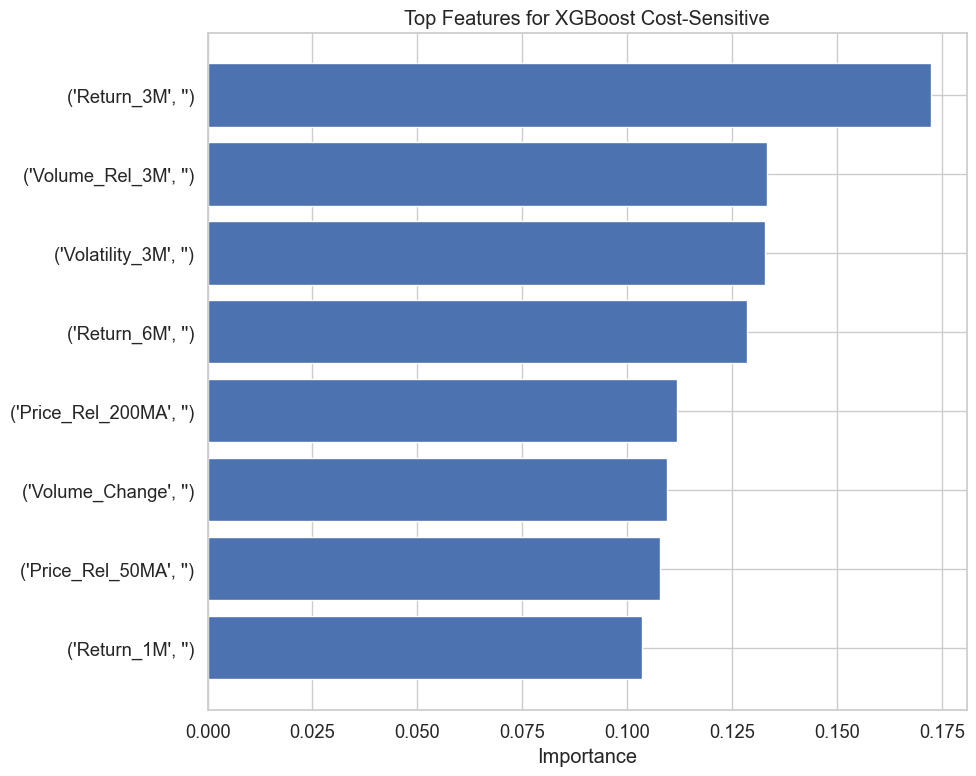

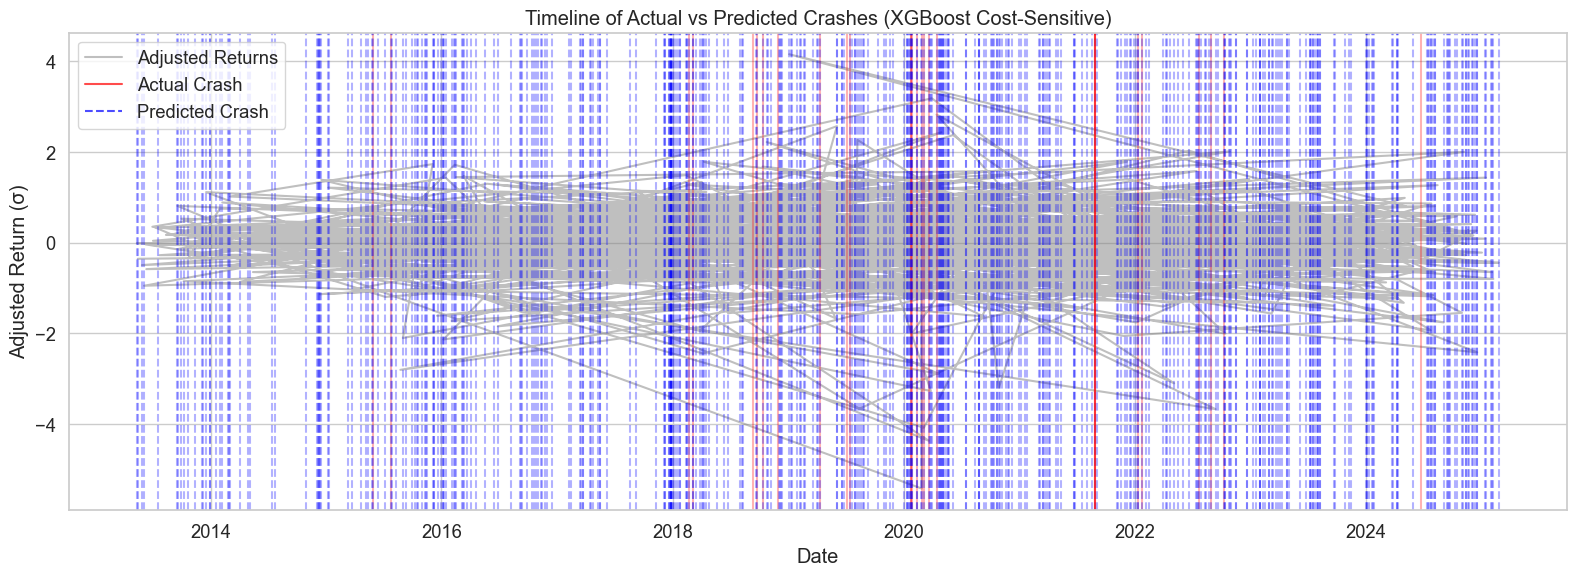

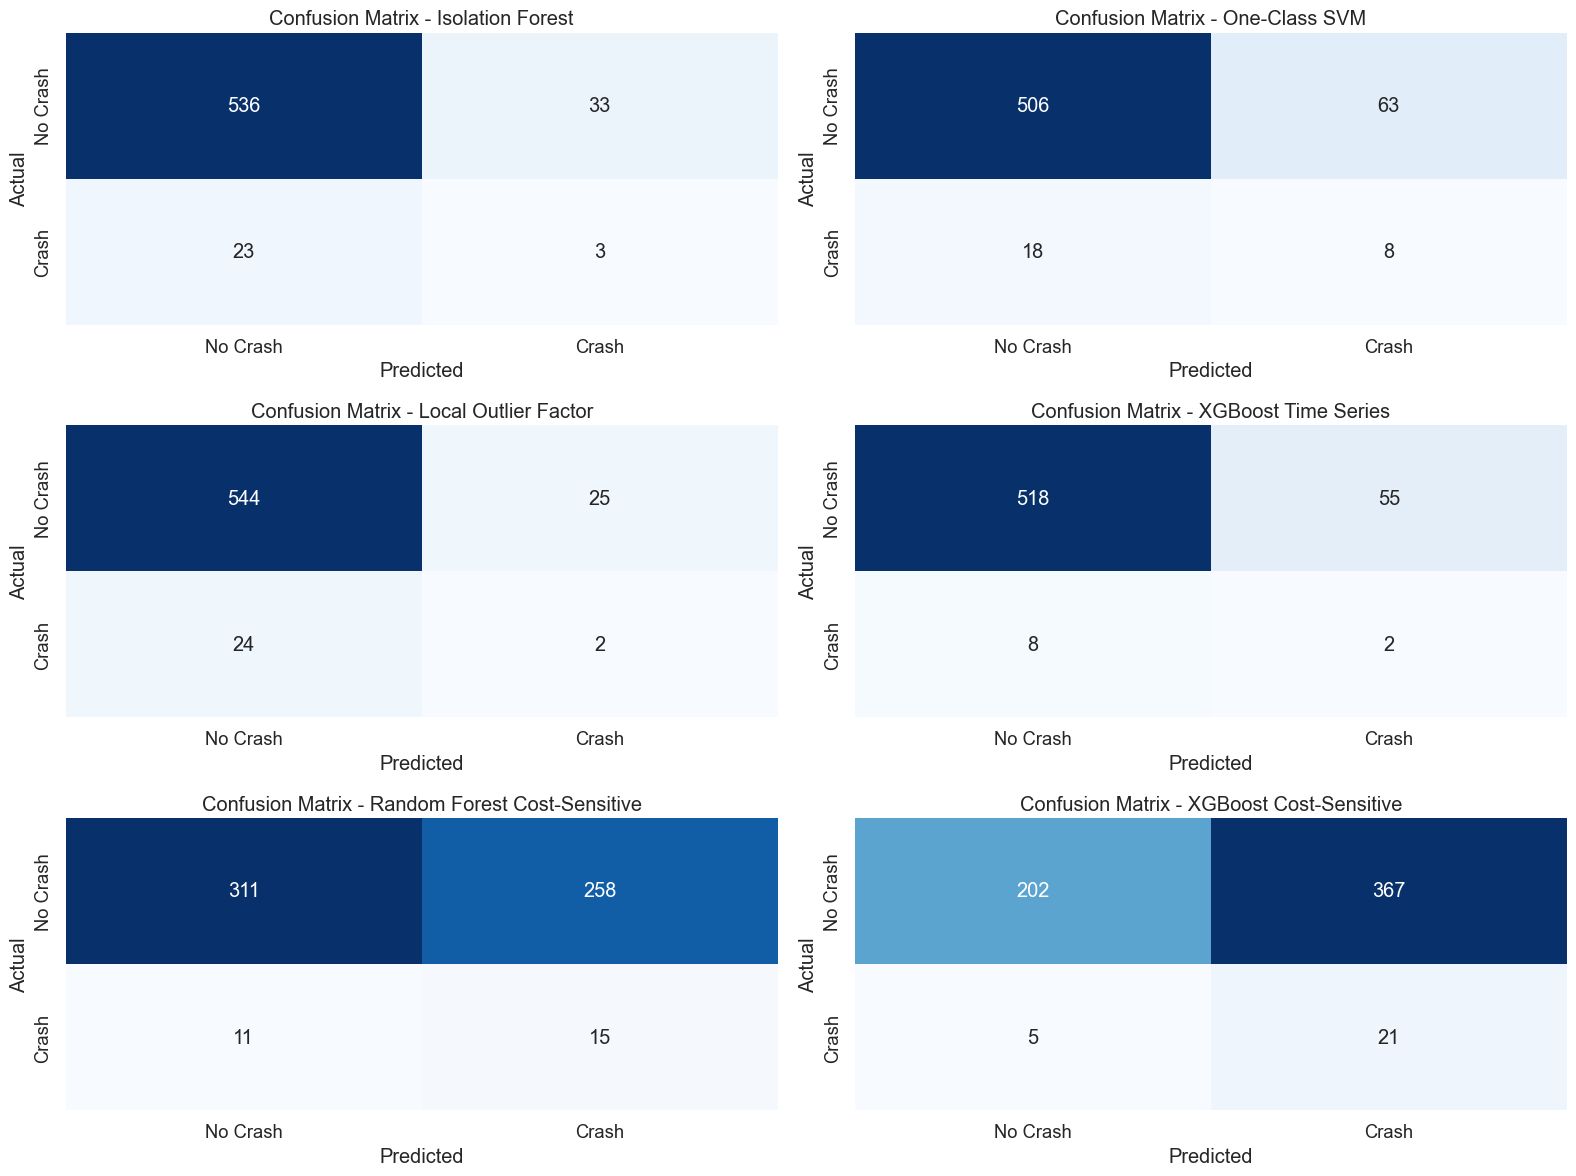

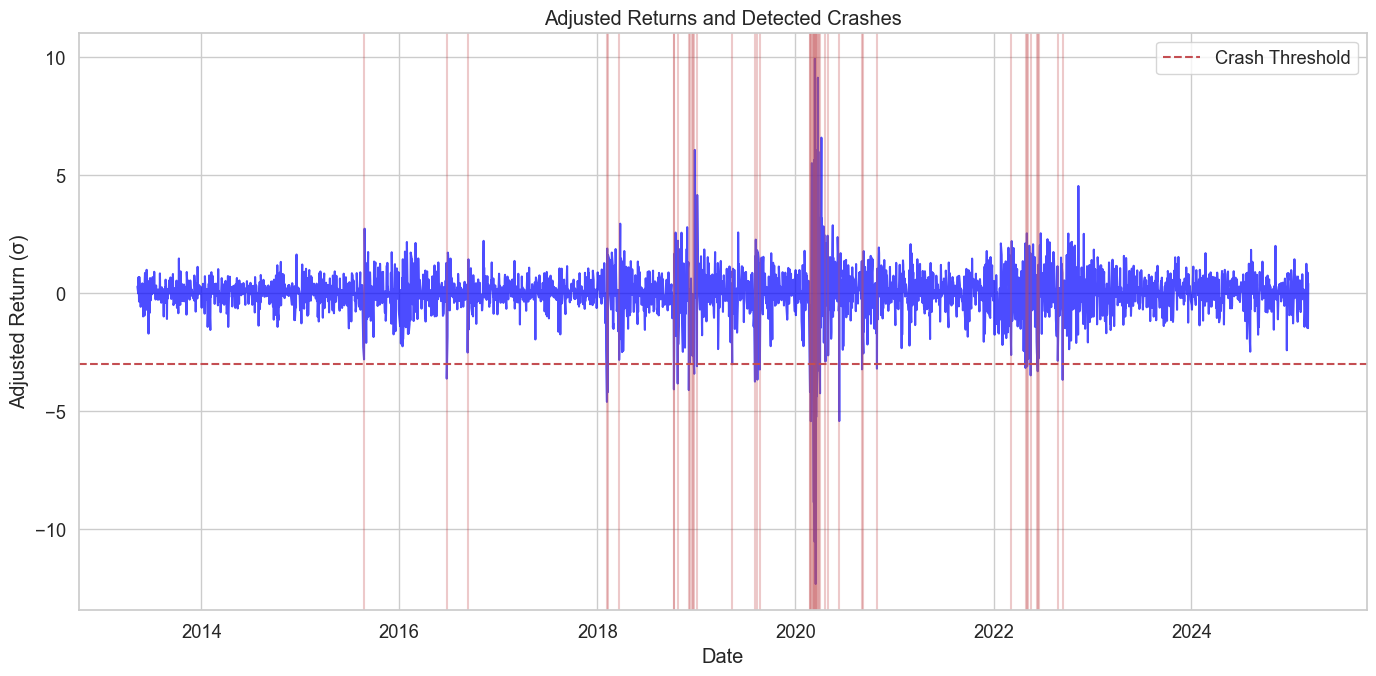

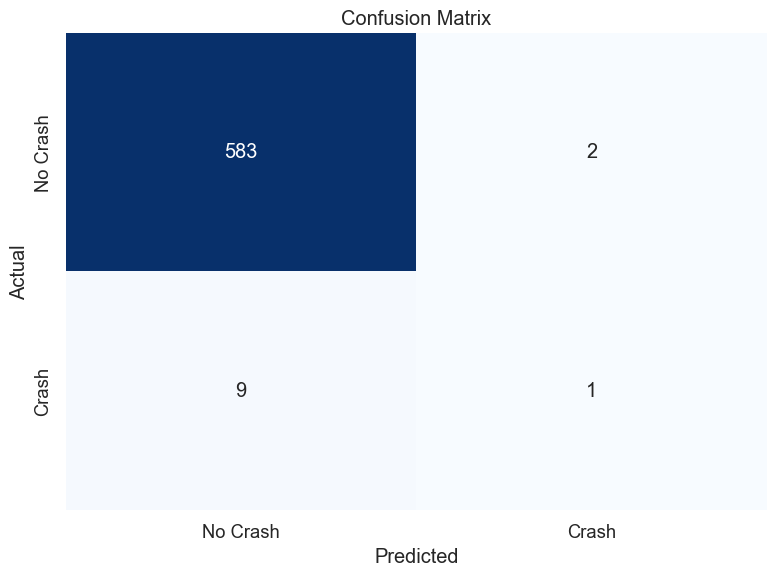

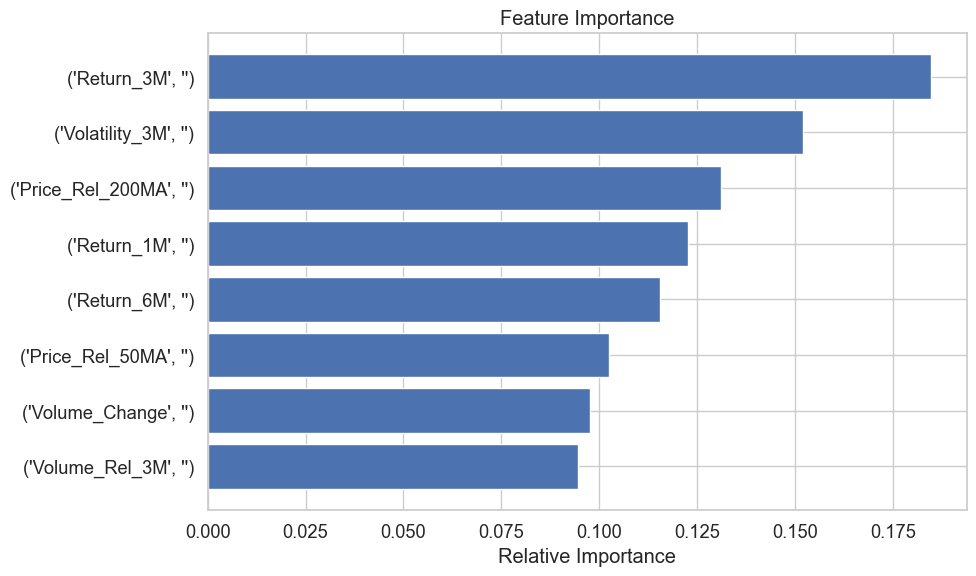

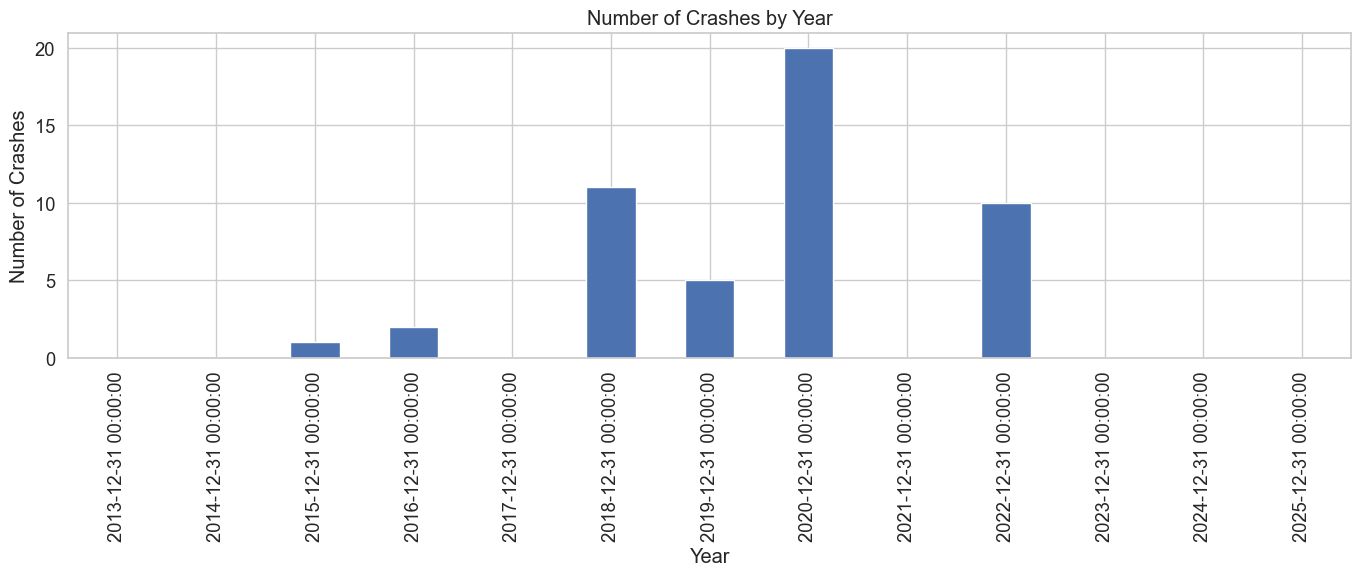

In [37]:
modelling(detection_method='boxplot')

[*********************100%***********************]  1 of 1 completed

Analyzing ^GSPC from 2005-07-22 to 2025-04-08
Using std_dev method for crash detection
Standard deviation threshold: -2.5
Detected 49 market crashes
Crash days: 1.65% of trading days

Top 10 Detected Crashes (by standard deviation):
Price      Return Adjusted_Return
Ticker                           
Date                             
2020-03-16 -11.98          -12.31
2020-03-12  -9.51          -10.53
2020-03-09  -7.60           -8.86
2020-03-11  -4.89           -5.61
2020-02-27  -4.42           -5.42
2020-06-11  -5.89           -5.42
2020-03-18  -5.18           -5.25
2018-02-05  -4.10           -4.61
2020-03-20  -4.34           -4.37
2020-04-01  -4.41           -4.24
Class imbalance: 0.0171 (proportion of crash days)

=== ANOMALY DETECTION MODELS ===

Isolation Forest:


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       585
         1.0       0.00      0.00      0.00        10

    accuracy                           0.96       595
   macro avg       0.49      0.49      0.49       595
weighted avg       0.97      0.96      0.96       595


One-Class SVM:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       585
         1.0       0.00      0.00      0.00        10

    accuracy                           0.94       595
   macro avg       0.49      0.48      0.49       595
weighted avg       0.97      0.94      0.95       595


Local Outlier Factor:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       585
         1.0       0.00      0.00      0.00        10

    accuracy                           0.96       595
   macro avg       0.49      0.49      0.49       595
weighted avg       0.97      0.96  

[*********************100%***********************]  1 of 1 completed


Analysis complete. Visualizations saved.
Detected 49 market crashes

Top 10 Detected Crashes:
Price      Return Adjusted_Return
Ticker                           
Date                             
2020-03-16 -11.98          -12.31
2020-03-12  -9.51          -10.53
2020-03-09  -7.60           -8.86
2020-03-11  -4.89           -5.61
2020-02-27  -4.42           -5.42
2020-06-11  -5.89           -5.42
2020-03-18  -5.18           -5.25
2018-02-05  -4.10           -4.61
2020-03-20  -4.34           -4.37
2020-04-01  -4.41           -4.24
Class imbalance: 0.0171 (proportion of crash days)


Using probability threshold: 0.5000
Model Evaluation:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       585
         1.0       0.33      0.10      0.15        10

    accuracy                           0.98       595
   macro avg       0.66      0.55      0.57       595
weighted avg       0.97      0.98      0.98       595


Feature Importance:
           Feature  Importance
2        Return_3M    0.184557
0    Volatility_3M    0.151926
5  Price_Rel_200MA    0.130980
1        Return_1M    0.122662
3        Return_6M    0.115490
4   Price_Rel_50MA    0.102398
6    Volume_Change    0.097533
7    Volume_Rel_3M    0.094453

Analysis complete. Visualizations saved.


<Figure size 1200x800 with 0 Axes>

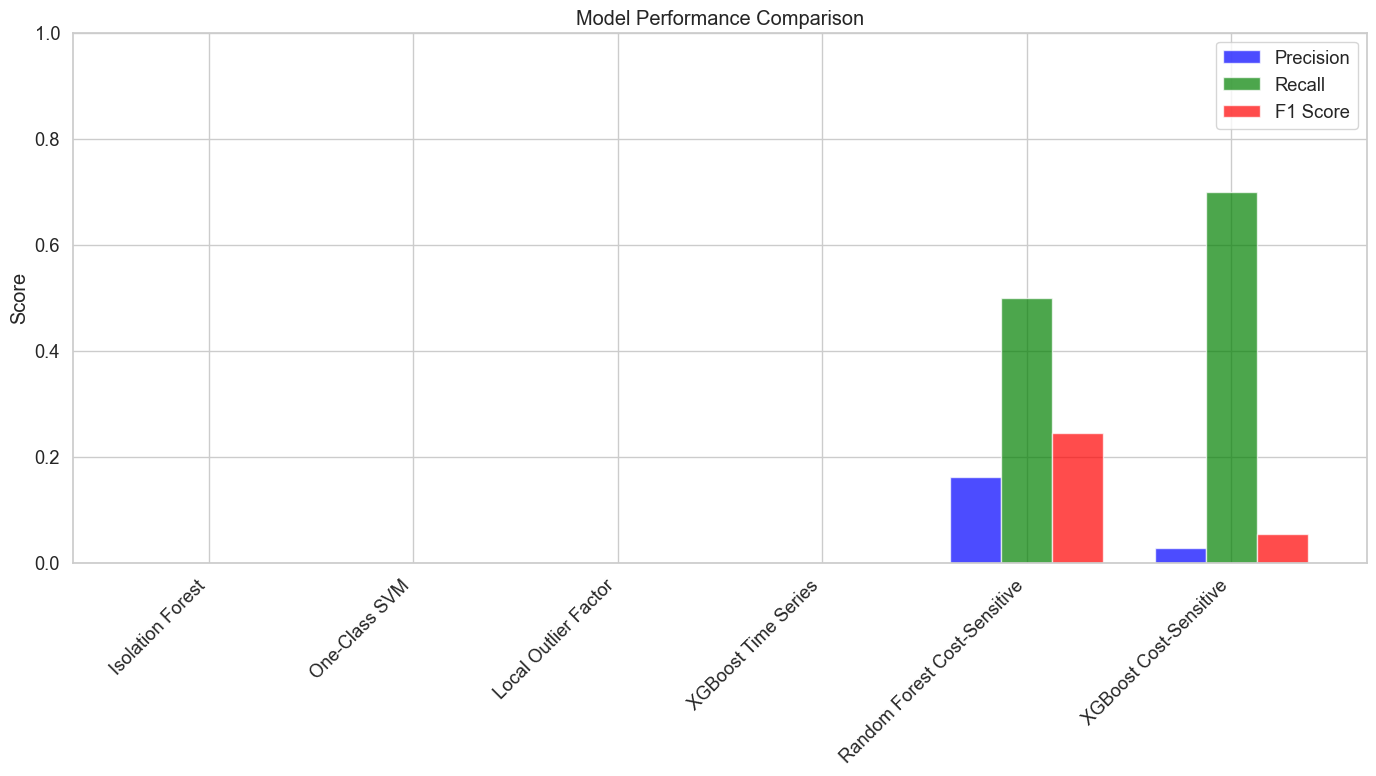

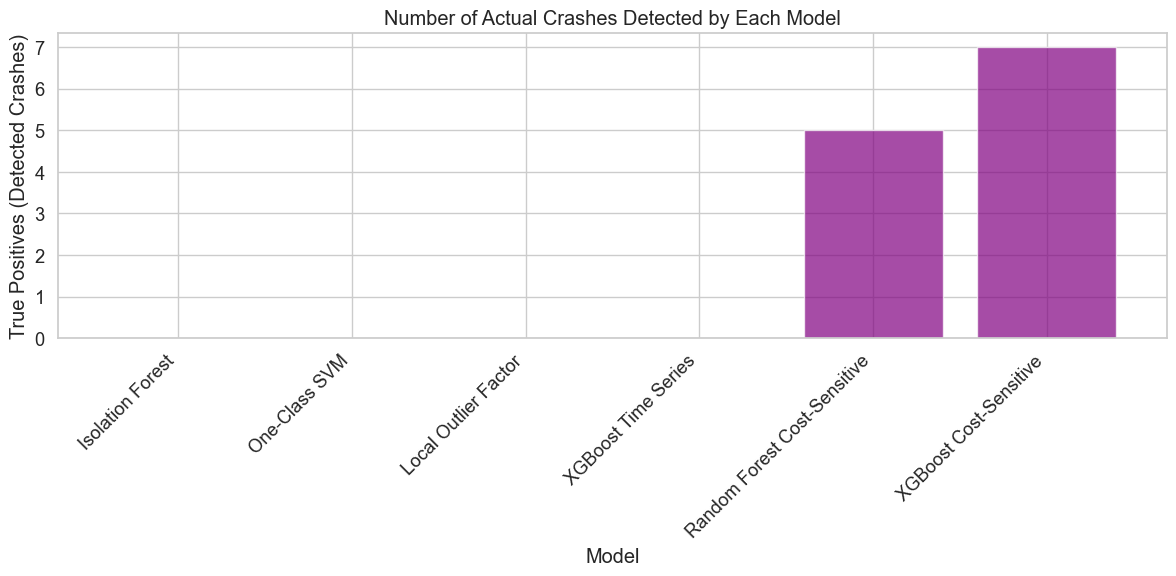

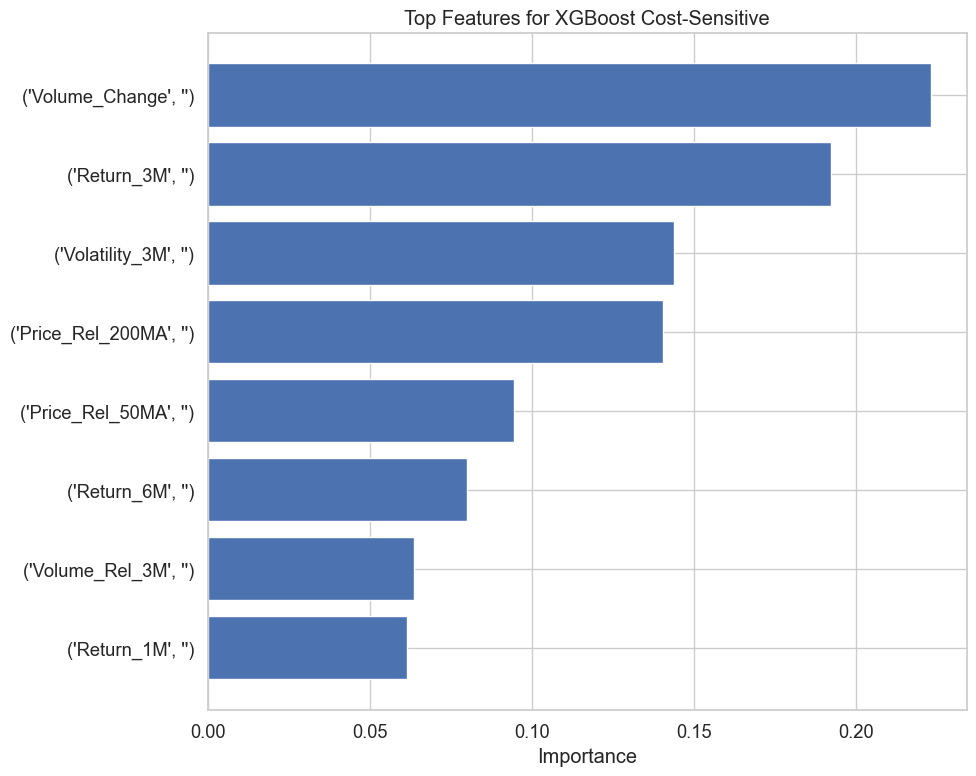

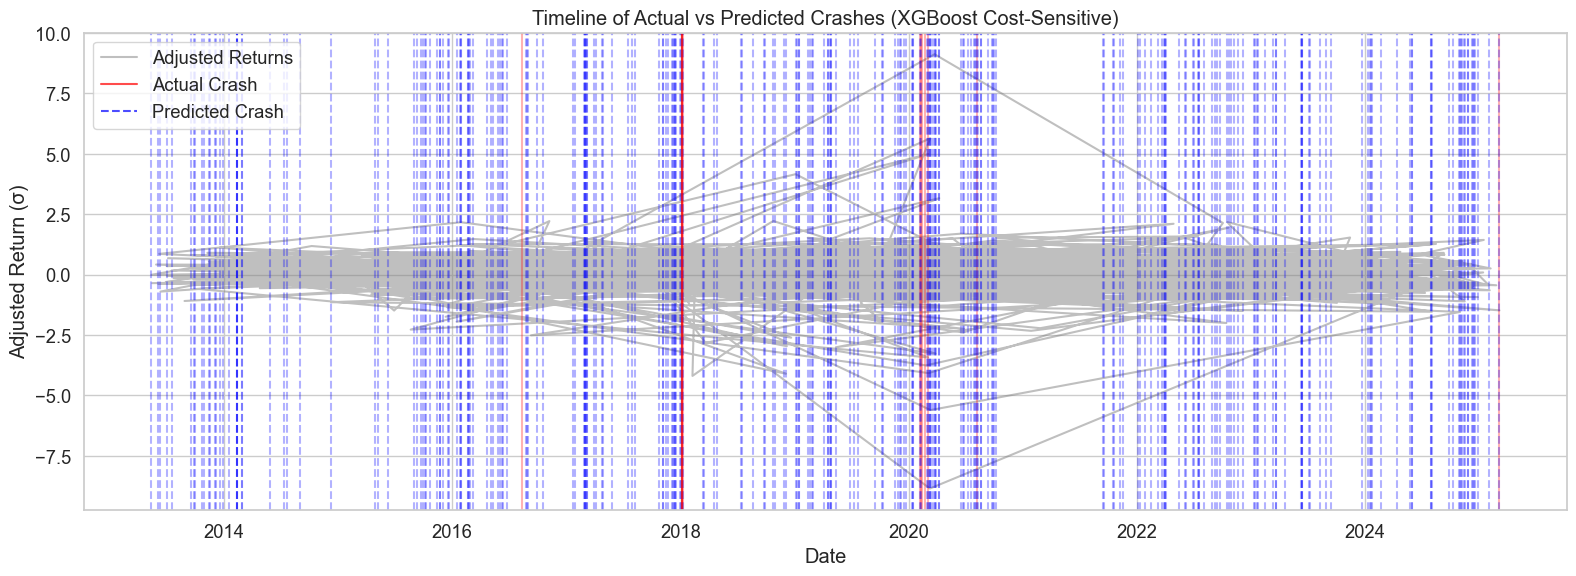

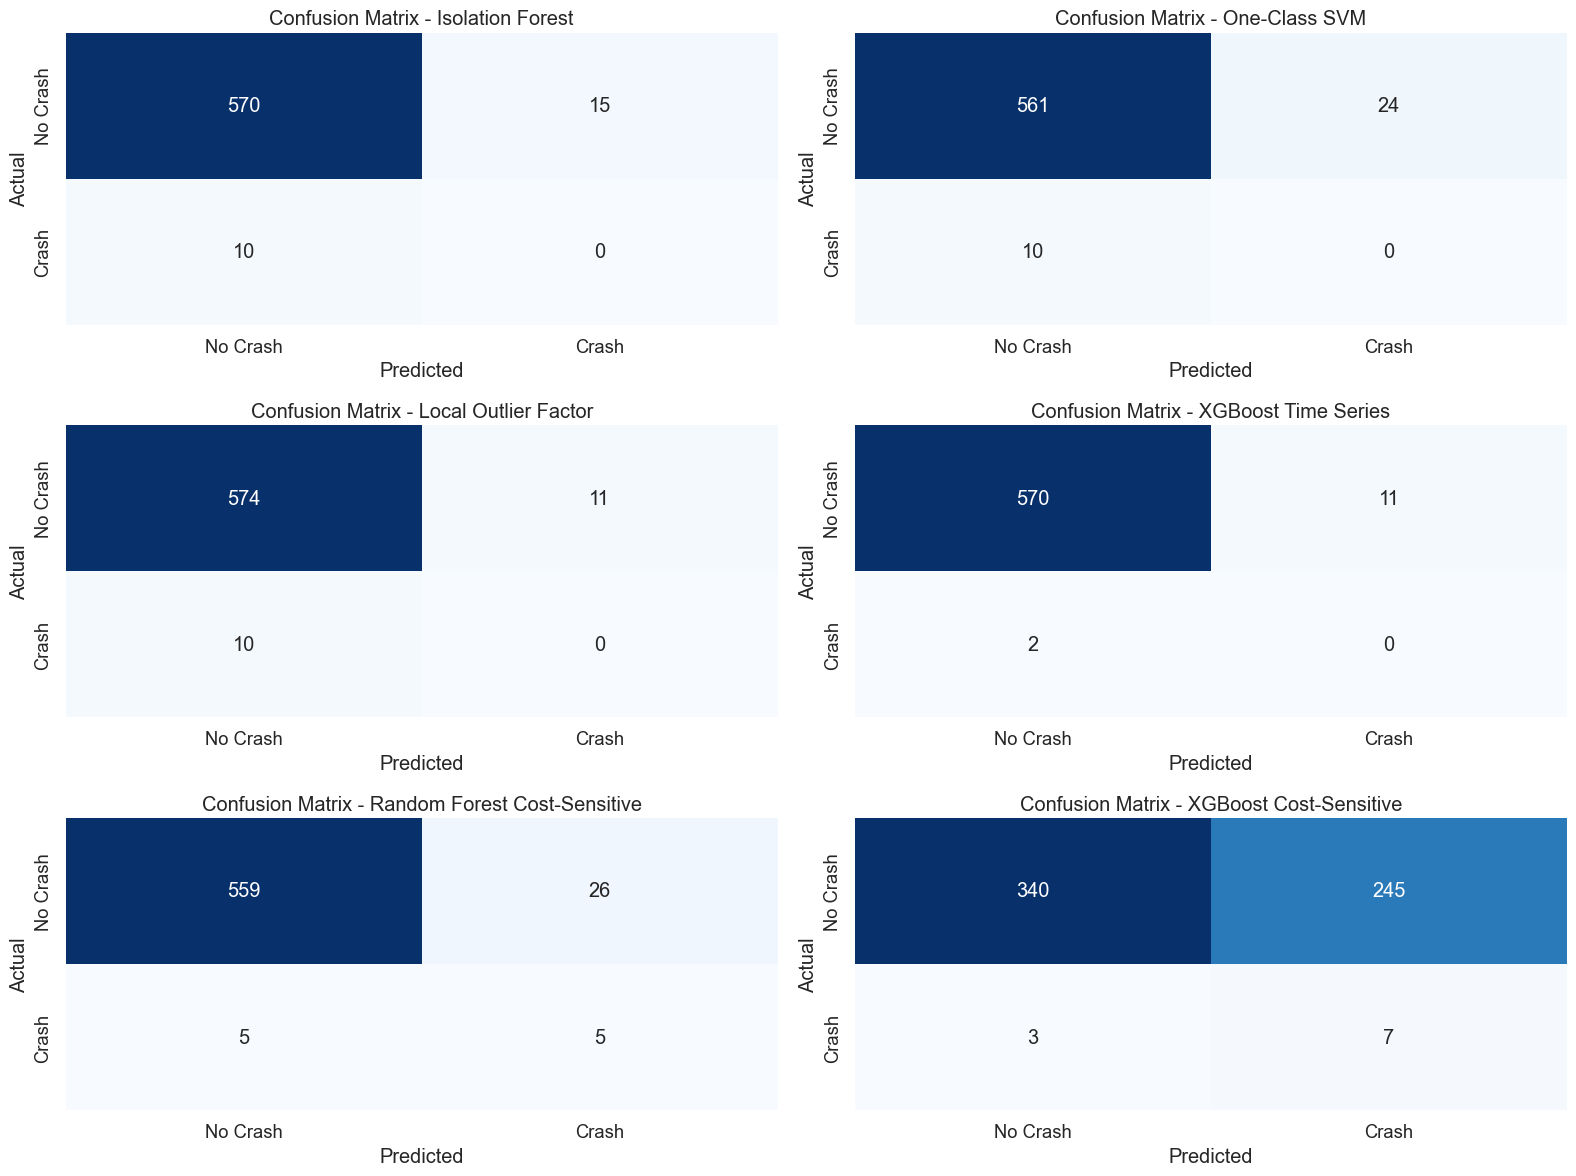

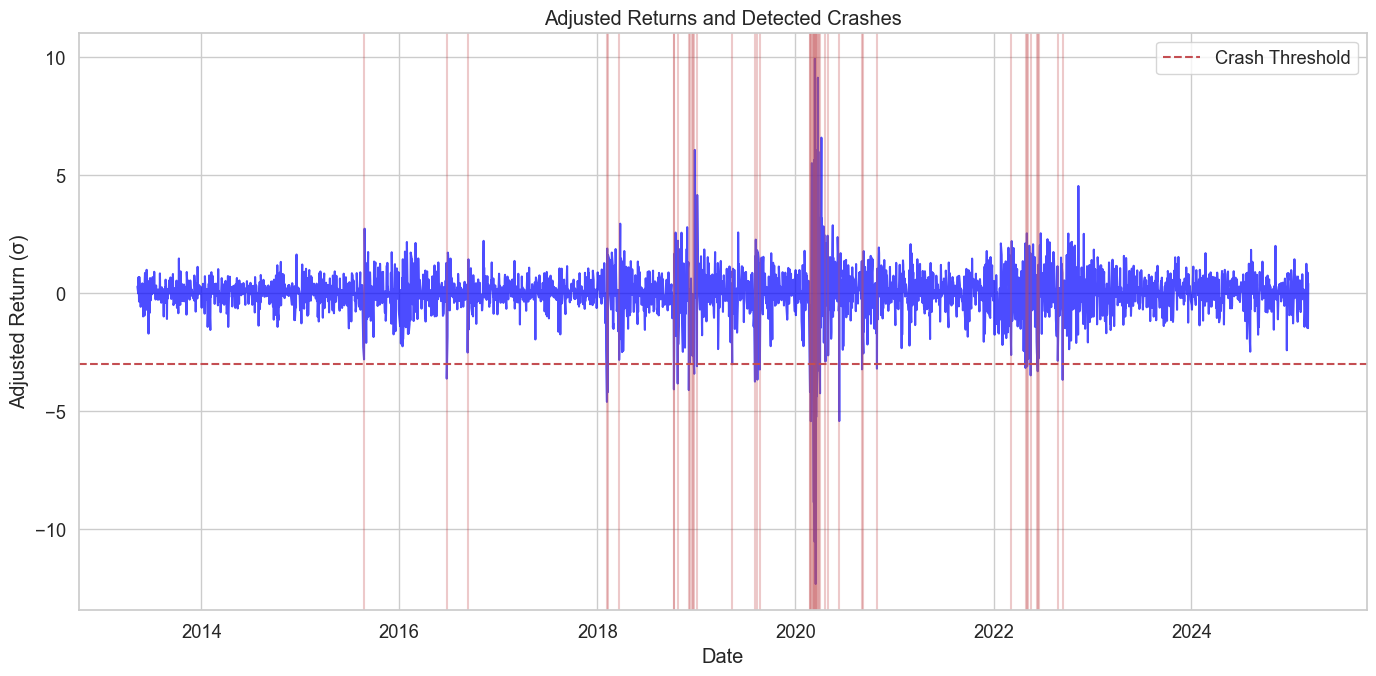

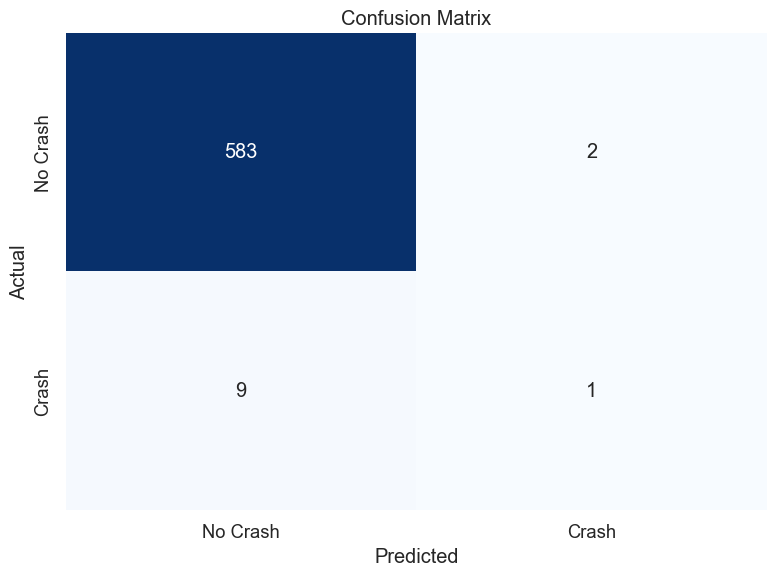

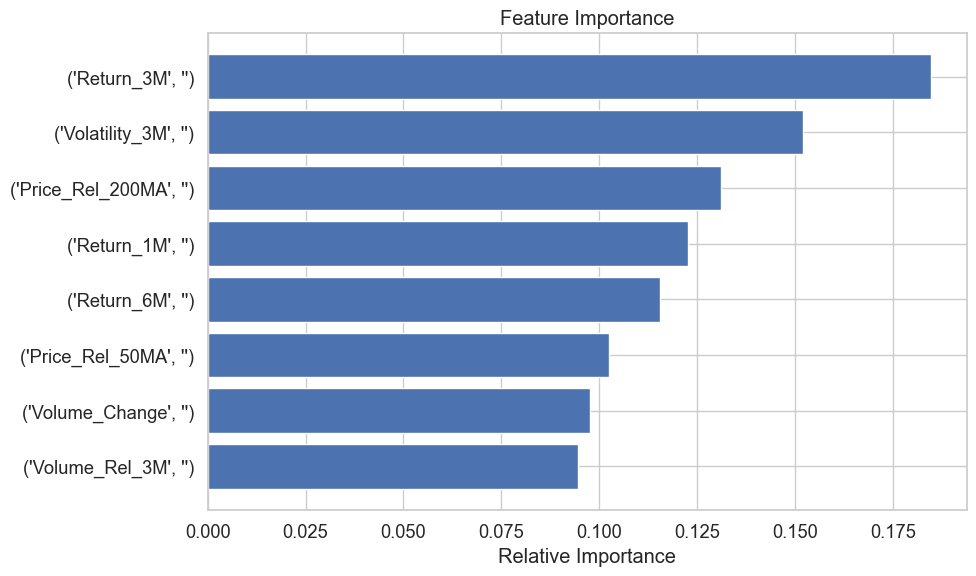

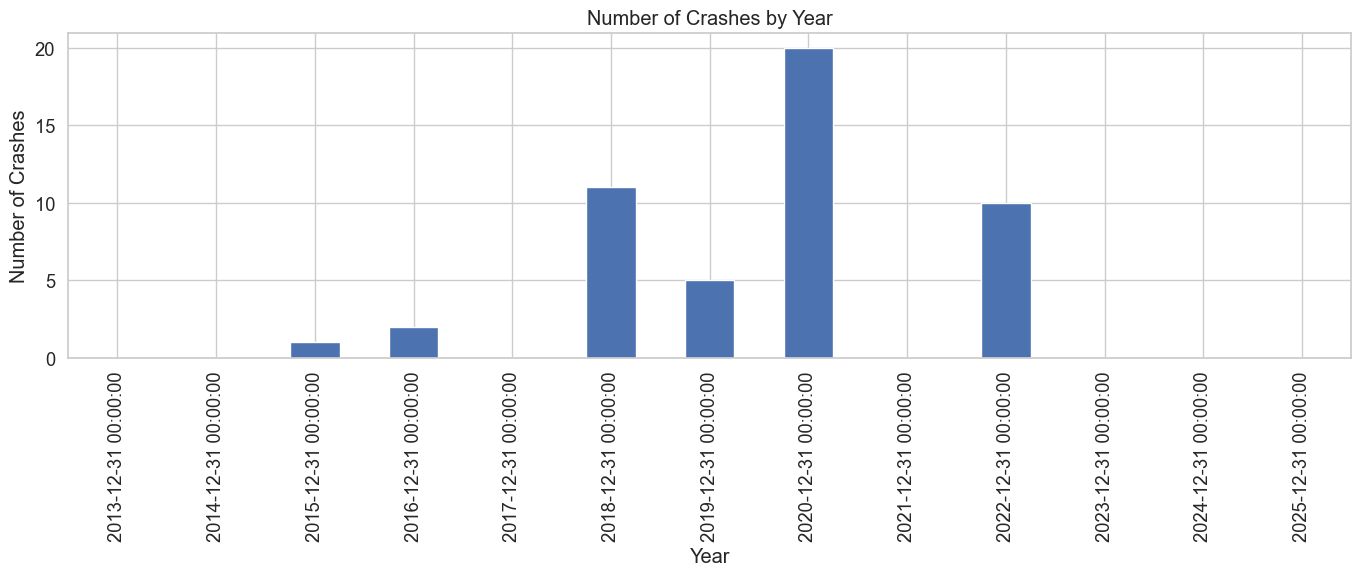

In [38]:
modelling(detection_method='std_dev')